# Partie Prophet (données journalières)

In [1]:
# Chargement de packages
library(tidyverse)
library(lubridate)
library(readr)
library(ggplot2)
library(readxl)
library(forecast)
library(gridExtra)
library(dplyr)
library(tseries)
library("stats")
library("tidyr")
library("ggplot2")

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"le package 'forecast' a été compilé avec la version R 4.3.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attachement du package : 'gridExtra'


L'objet suivant est masqué depuis 'package:dplyr':

    combine




In [2]:
resultat = read.csv("journaliere.csv")

In [3]:
head(resultat,5)

date       nombre_employes_entree nombre_employes_sortie
1 2014-06-09 1                      0                     
2 2014-06-10 0                      0                     
3 2014-06-11 0                      0                     
4 2014-06-12 0                      0                     
5 2014-06-13 0                      0                     
  nombre_employes_total
1 1                    
2 1                    
3 1                    
4 1                    
5 1

Prophet est un package conçu par Facebook pour la prévision des séries temporelles, offrant une approche flexible et intuitive pour modéliser des données temporelles complexes. Son intérêt réside dans sa capacité à gérer efficacement des séries temporelles avec des tendances non linéaires, des effets saisonniers et des vacances.

In [4]:
library(prophet)

Warning message:
"le package 'prophet' a été compilé avec la version R 4.3.2"
Le chargement a nécessité le package : Rcpp

Le chargement a nécessité le package : rlang


Attachement du package : 'rlang'


Les objets suivants sont masqués depuis 'package:purrr':

    %@%, flatten, flatten_chr, flatten_dbl, flatten_int, flatten_lgl,
    flatten_raw, invoke, splice




In [5]:
tail(resultat,10)

date       nombre_employes_entree nombre_employes_sortie
3480 2023-12-18 0                      0                     
3481 2023-12-19 0                      0                     
3482 2023-12-20 0                      0                     
3483 2023-12-21 0                      0                     
3484 2023-12-22 0                      0                     
3485 2023-12-23 0                      0                     
3486 2023-12-24 0                      0                     
3487 2023-12-25 0                      1                     
3488 2023-12-26 0                      0                     
3489 2023-12-27 0                      1                     
     nombre_employes_total
3480 202                  
3481 202                  
3482 202                  
3483 202                  
3484 202                  
3485 202                  
3486 202                  
3487 201                  
3488 201                  
3489 200

## Split des données en train et test

In [6]:
data <- resultat[,c("date","nombre_employes_total")]

In [7]:
length = round(nrow(data)*0.8)
length

[1] 2791

In [8]:
data_train = resultat[1:length,c("date","nombre_employes_total")]

In [9]:
data_test = resultat[(length+1):nrow(data),c("date","nombre_employes_total")]

In [10]:
nrow(data)
nrow(data_train)
nrow(data_test)

[1] 3489

[1] 2791

[1] 698

In [11]:
head(data_train,5)

date       nombre_employes_total
1 2014-06-09 1                    
2 2014-06-10 1                    
3 2014-06-11 1                    
4 2014-06-12 1                    
5 2014-06-13 1

Conformément à les noms de colonnes demandées par Prophet, nous allons nommer les noms des colonnes de date de du nombre total d'employés respectivement par **ds** et **y**.

In [12]:
colnames(data_train) <- c("ds", "y") -> colnames(data_test)

In [13]:
m = prophet(data_train)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [14]:
m %>% head(5)

$growth
[1] "linear"

$changepoints
 [1] "2014-09-06 GMT" "2014-12-04 GMT" "2015-03-04 GMT" "2015-06-01 GMT"
 [5] "2015-08-29 GMT" "2015-11-26 GMT" "2016-02-24 GMT" "2016-05-23 GMT"
 [9] "2016-08-20 GMT" "2016-11-17 GMT" "2017-02-15 GMT" "2017-05-15 GMT"
[13] "2017-08-12 GMT" "2017-11-09 GMT" "2018-02-07 GMT" "2018-05-07 GMT"
[17] "2018-08-04 GMT" "2018-11-01 GMT" "2019-01-30 GMT" "2019-04-29 GMT"
[21] "2019-07-27 GMT" "2019-10-24 GMT" "2020-01-22 GMT" "2020-04-20 GMT"
[25] "2020-07-18 GMT"

$n.changepoints
[1] 25

$changepoint.range
[1] 0.8

$yearly.seasonality
[1] "auto"


Par défaut, Prophet choisit comme valeur des hyperparamètres : 
- **growth** : "linear" ;
- **n.changepoints** : 25 ;
- **changepoint.range** : 0.8 ;
- **yearly.seasonality** : "auto"

## Voir le comportement du modèle par défaut (sans holidays and events)

Pour voir le comportement du modèle prophet, nous allons définir avec la fonction make_future_dataframe (fonction du package prophet) pour définir le nombre de date pour lequel on veut faire une prédiction avec le modèle. Nous en ferons pour une année, soit 365 jours.$\newline$ Ensuite, nous ferons la prédiction pour ces 365 jours et plotter les composantes du modèle prophet.

In [15]:
future = m %>% make_future_dataframe(freq = "day",periods = nrow(data_test))

In [16]:
forecast_default = m %>% predict(future)

In [17]:
forecast = predict(m, data_test)

In [18]:
mean_absolute_percentage_error <- function(y_true, y_pred) {
  y_true <- as.numeric(y_true)
  y_pred <- as.numeric(y_pred)
  mean(abs((y_true - y_pred) / y_true)) * 100
}

In [19]:
mean_absolute_percentage_error(data_test$y,forecast$yhat)

[1] 12.10151

In [20]:
mean_absolute_percentage_error(data_test$y,forecast_default$yhat)

Warning message in y_true - y_pred:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"
Warning message in (y_true - y_pred)/y_true:
"la taille d'un objet plus long n'est pas multiple de la taille d'un objet plus court"


[1] 43.25114

In [21]:
nrow(forecast)

[1] 698

In [22]:
forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]%>% head(7)

ds         yhat     yhat_lower yhat_upper
1 2022-01-29 152.1093 148.1669   155.8758  
2 2022-01-30 152.0002 148.2487   155.4810  
3 2022-01-31 152.1974 148.5101   155.8784  
4 2022-02-01 152.1841 148.5583   155.8367  
5 2022-02-02 152.1543 148.5221   155.8301  
6 2022-02-03 152.1245 148.5323   156.1234  
7 2022-02-04 151.9909 148.5752   155.5755

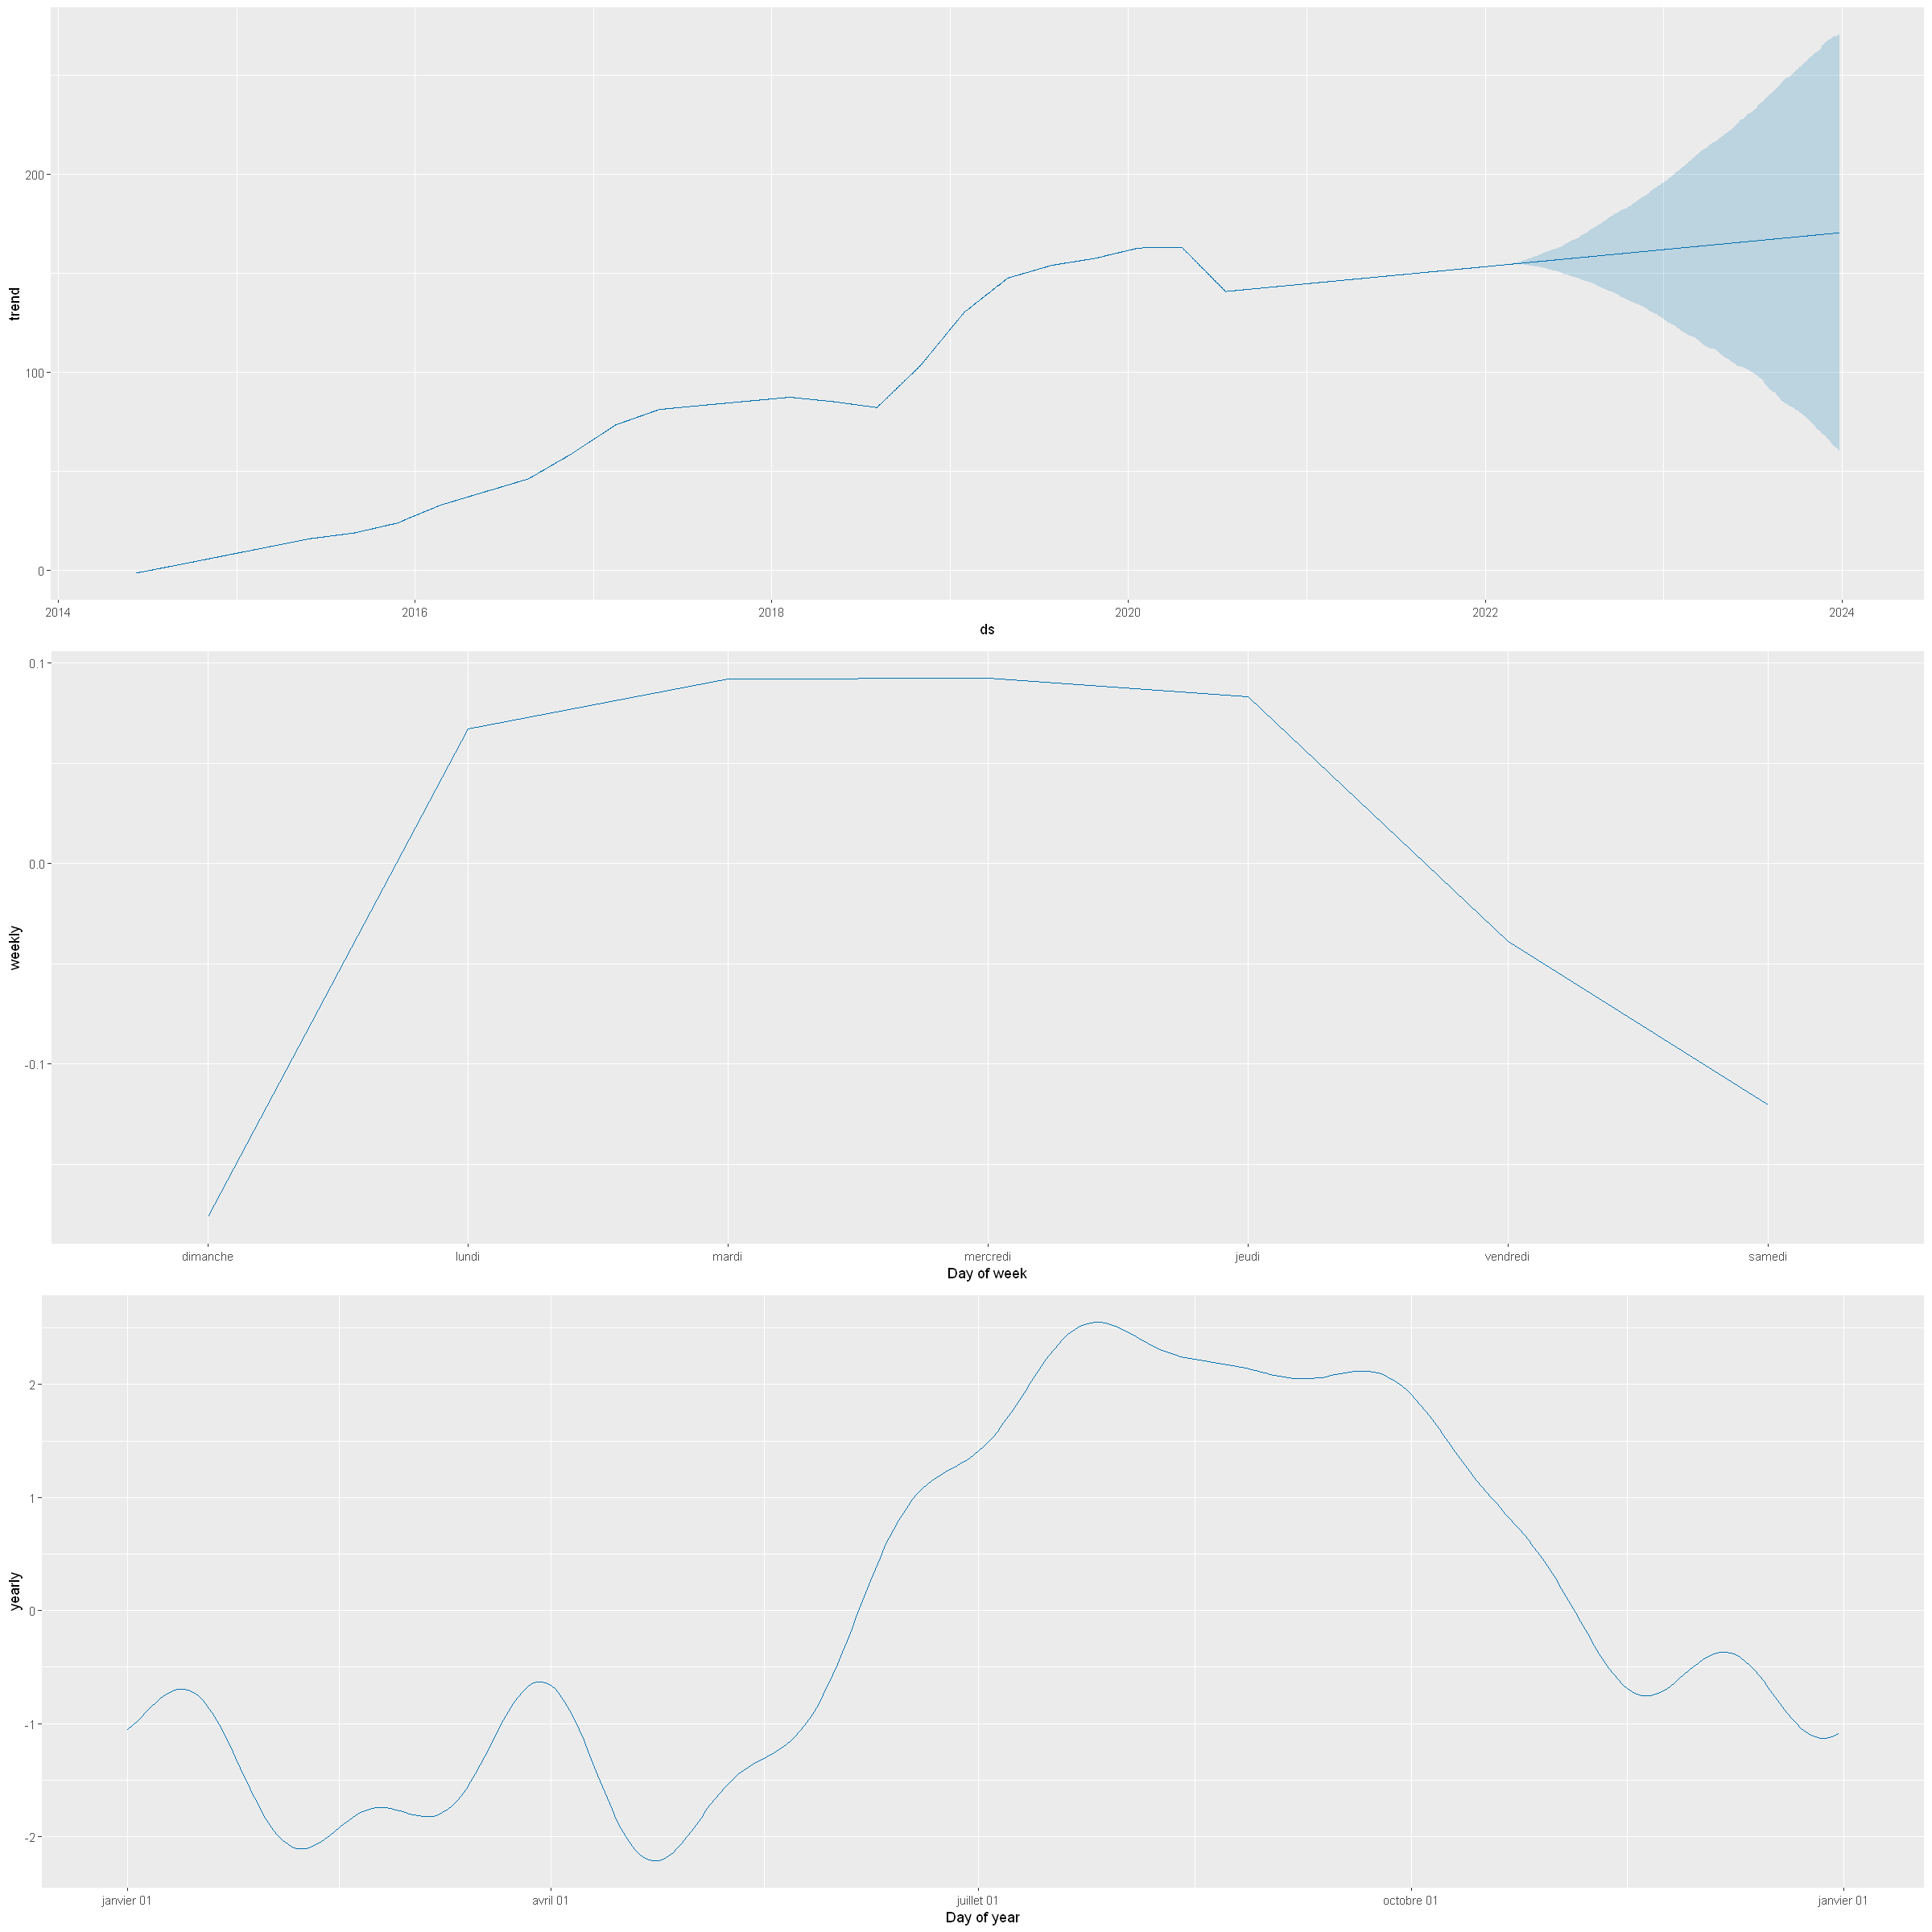

In [23]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=20)

prophet_plot_components(m, forecast_default)

Cette figure qui plotte les composantes des prédictions du modèle montre les périodes (en termes d'années, de mois et de jours) pour lesquels on note un nombre élevé d'entrée des employés et les périodes pour lesquelles le nombre d'employés est faible.

Prochaines étapes pour Prophet :

- Voir les performances du modèle prophet par défaut
- Inclure les jours fériés (holidays)
- Faire un tunning des hyperparamètres pour trouver le meilleur modèle
- Voir les performances du modèle retenu (prédictions, résidus,...)
- Présenter les limites de ce modèle
- Comparer ce modèle à celui classique

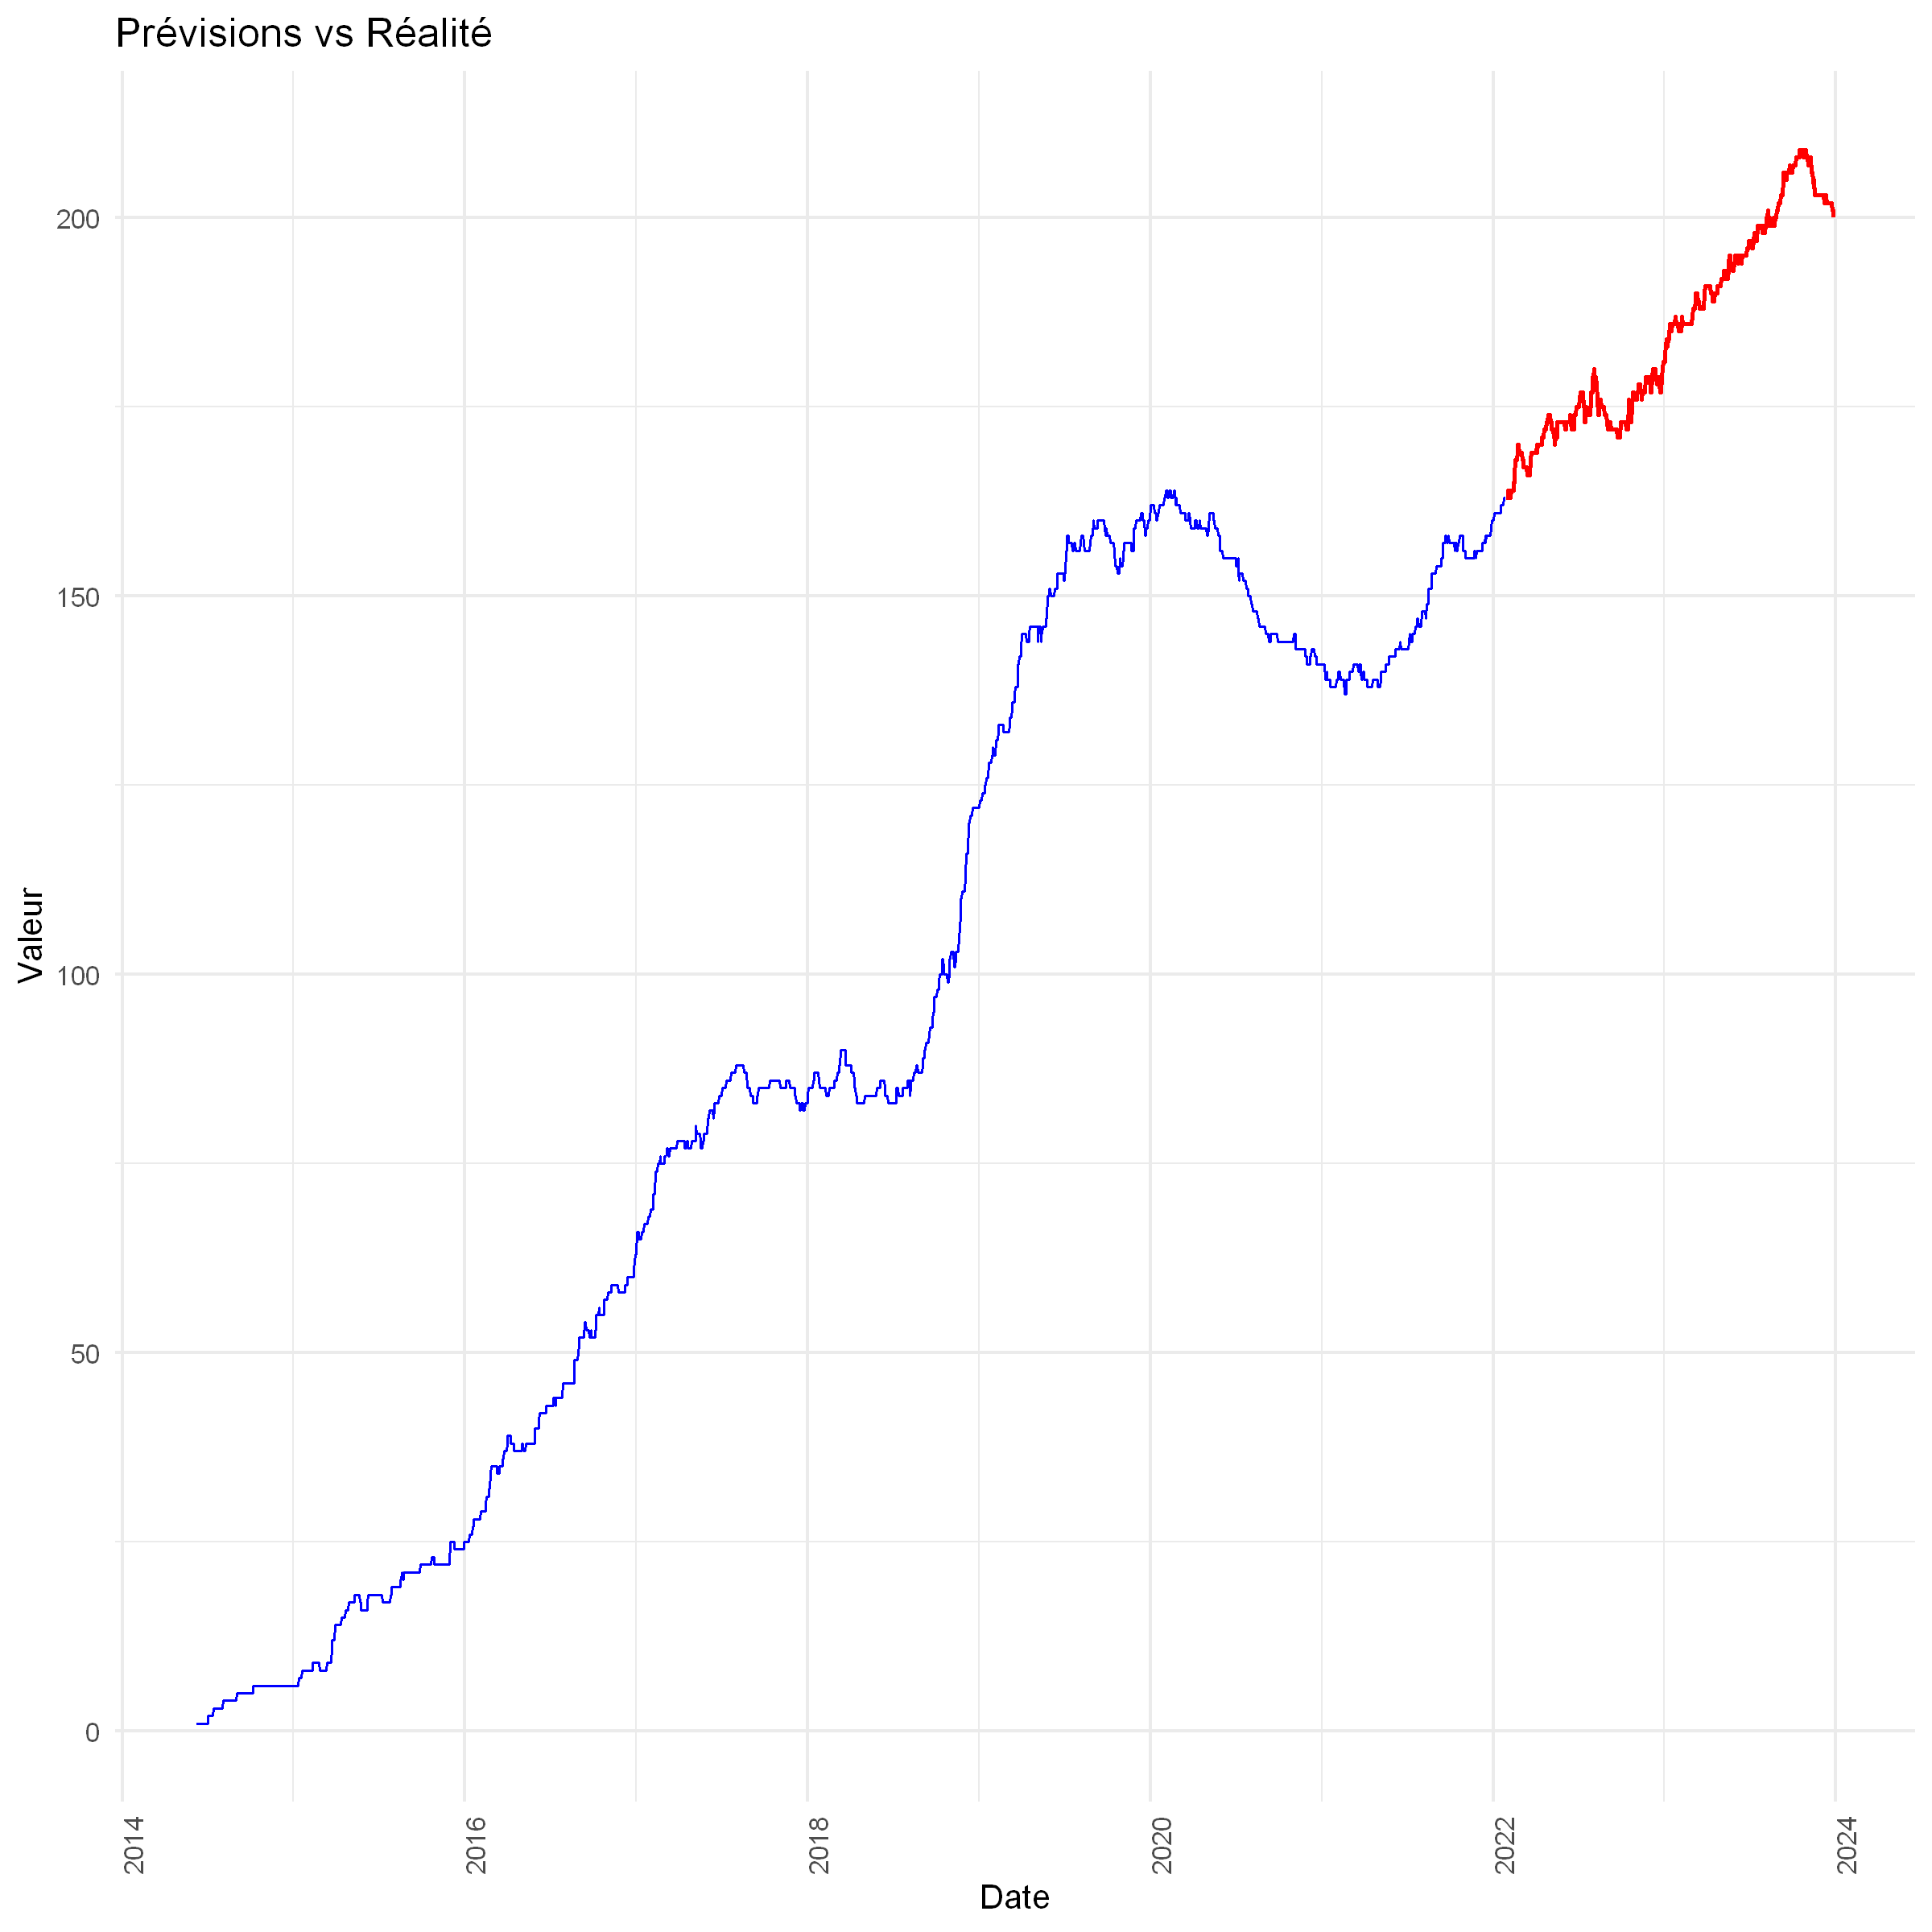

In [24]:
ggplot() +
  geom_line(data = data_train, aes(x = as.Date(ds), y = y, group = 1), color = "blue", linewidth = 1) +
  geom_line(data = data_test, aes(x = as.Date(ds), y = y, group = 1), color = "red", linewidth = 1.5) +
  labs(title = "Prévisions vs Réalité", x = "Date", y = "Valeur", color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right",
       axis.text.x = element_text(angle = 90, hjust = 1))


### Graphique des prévisions par le modèle sur les données simulées

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


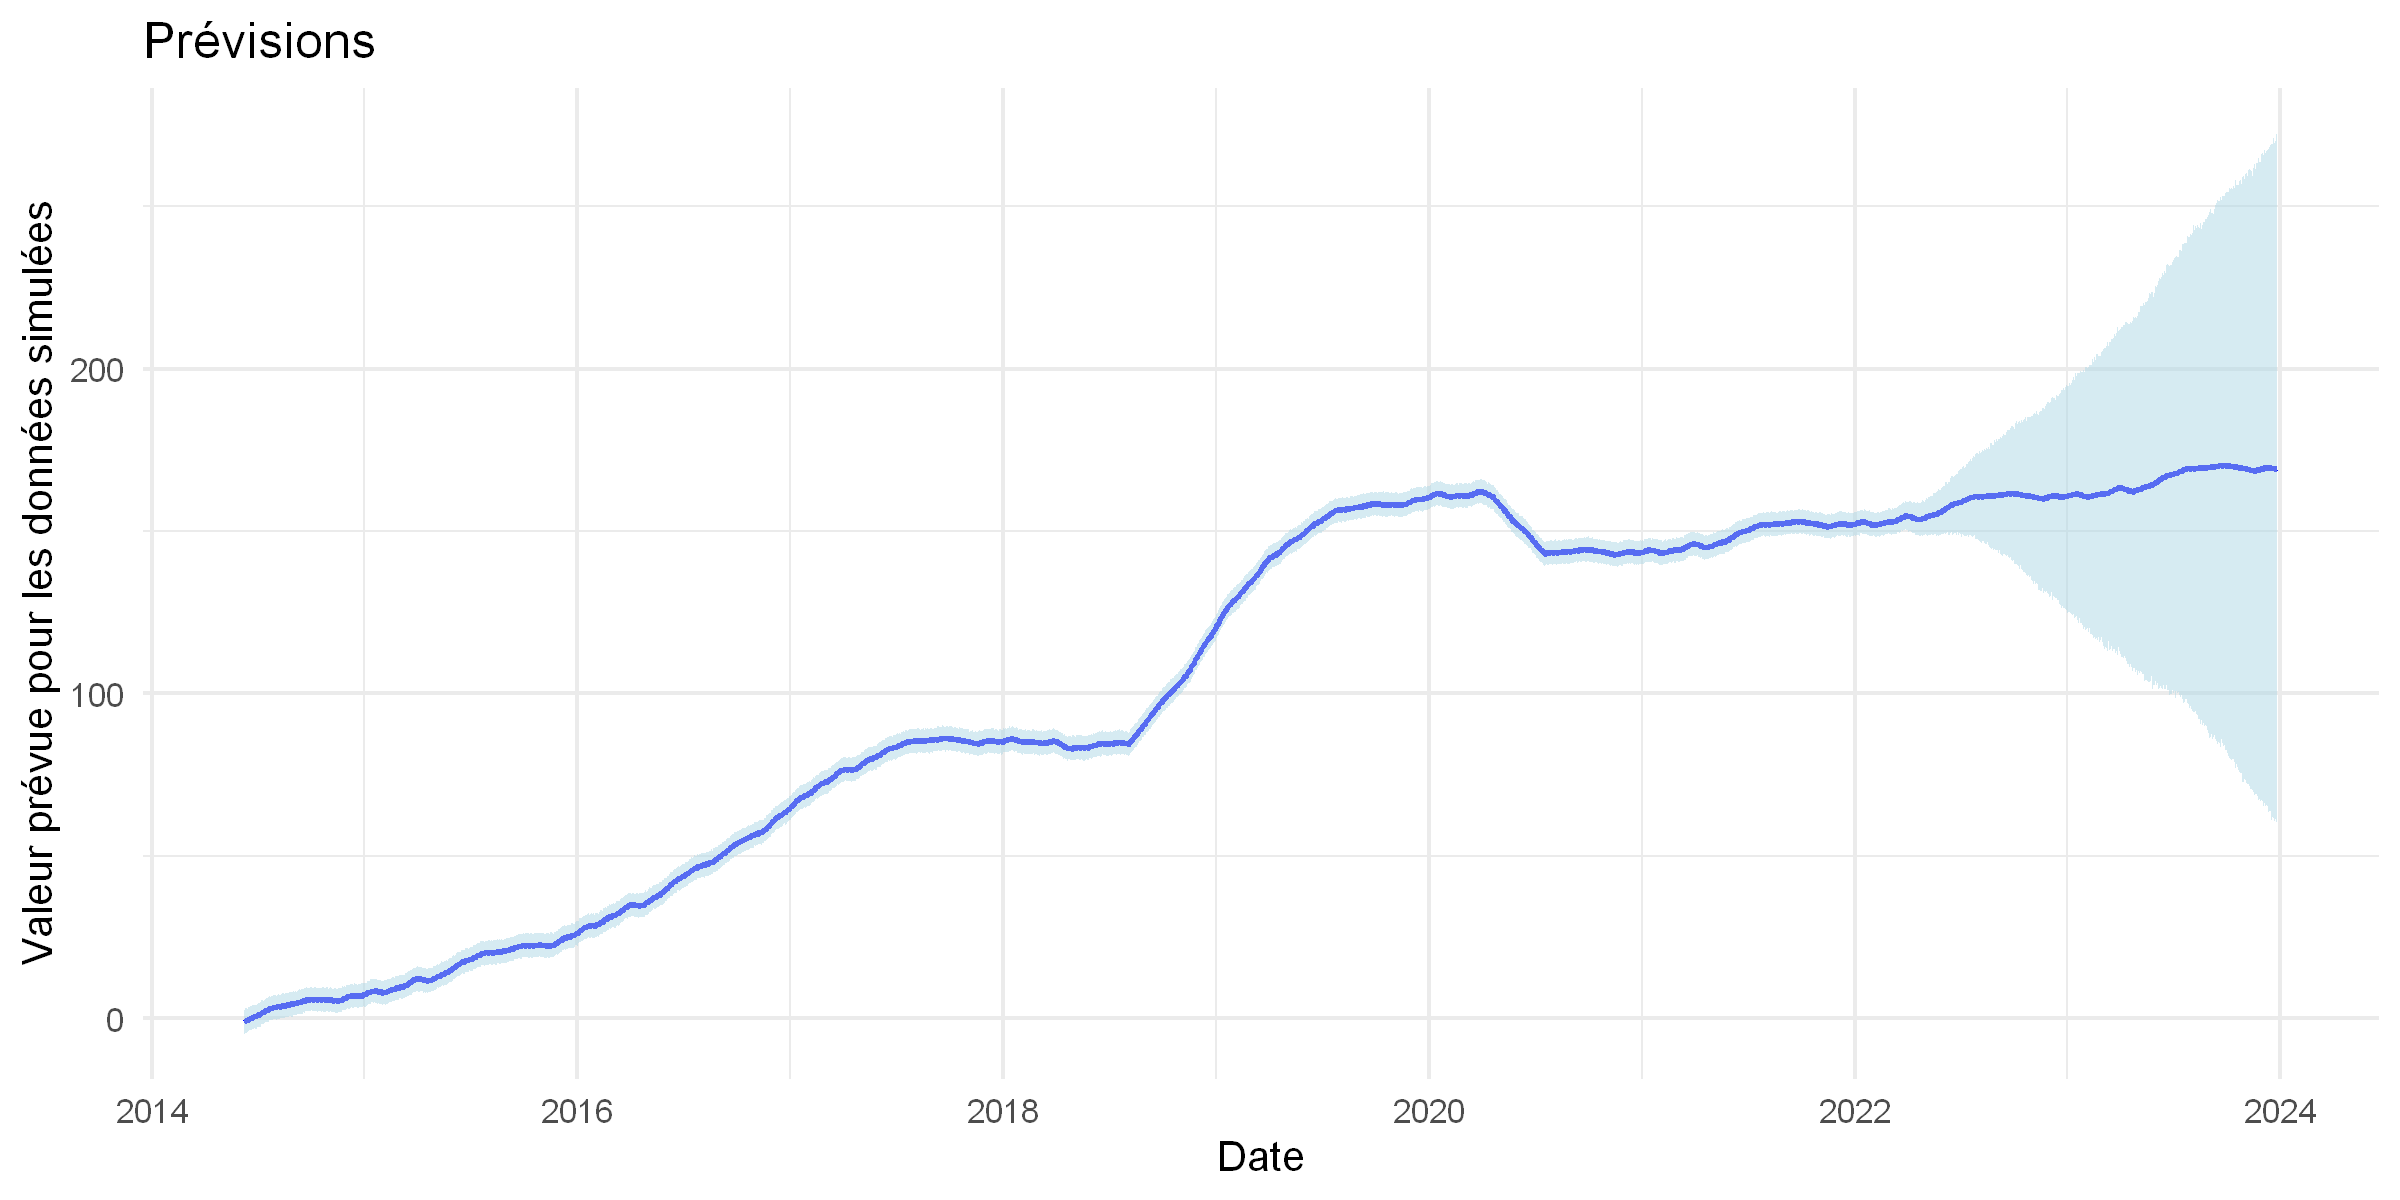

In [25]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +
  geom_line(data = forecast_default, aes(x = ds, y = yhat), color = "blue", size = 1.5) +
  geom_ribbon(data = forecast_default, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions",
       x = "Date",
       y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)

## Comparaison des valeurs réelles à celles prédites

In [26]:
data_test_forecast = m %>% predict(data_test)
data_test_forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')] %>% head(7)

ds         yhat     yhat_lower yhat_upper
1 2022-01-29 152.1093 148.3873   155.7300  
2 2022-01-30 152.0002 148.3319   155.6476  
3 2022-01-31 152.1974 148.5730   156.0398  
4 2022-02-01 152.1841 148.4071   155.7065  
5 2022-02-02 152.1543 149.0134   155.6431  
6 2022-02-03 152.1245 148.1638   155.7135  
7 2022-02-04 151.9909 148.6483   155.7952

### Graphiques des prédictions avec les données réelles

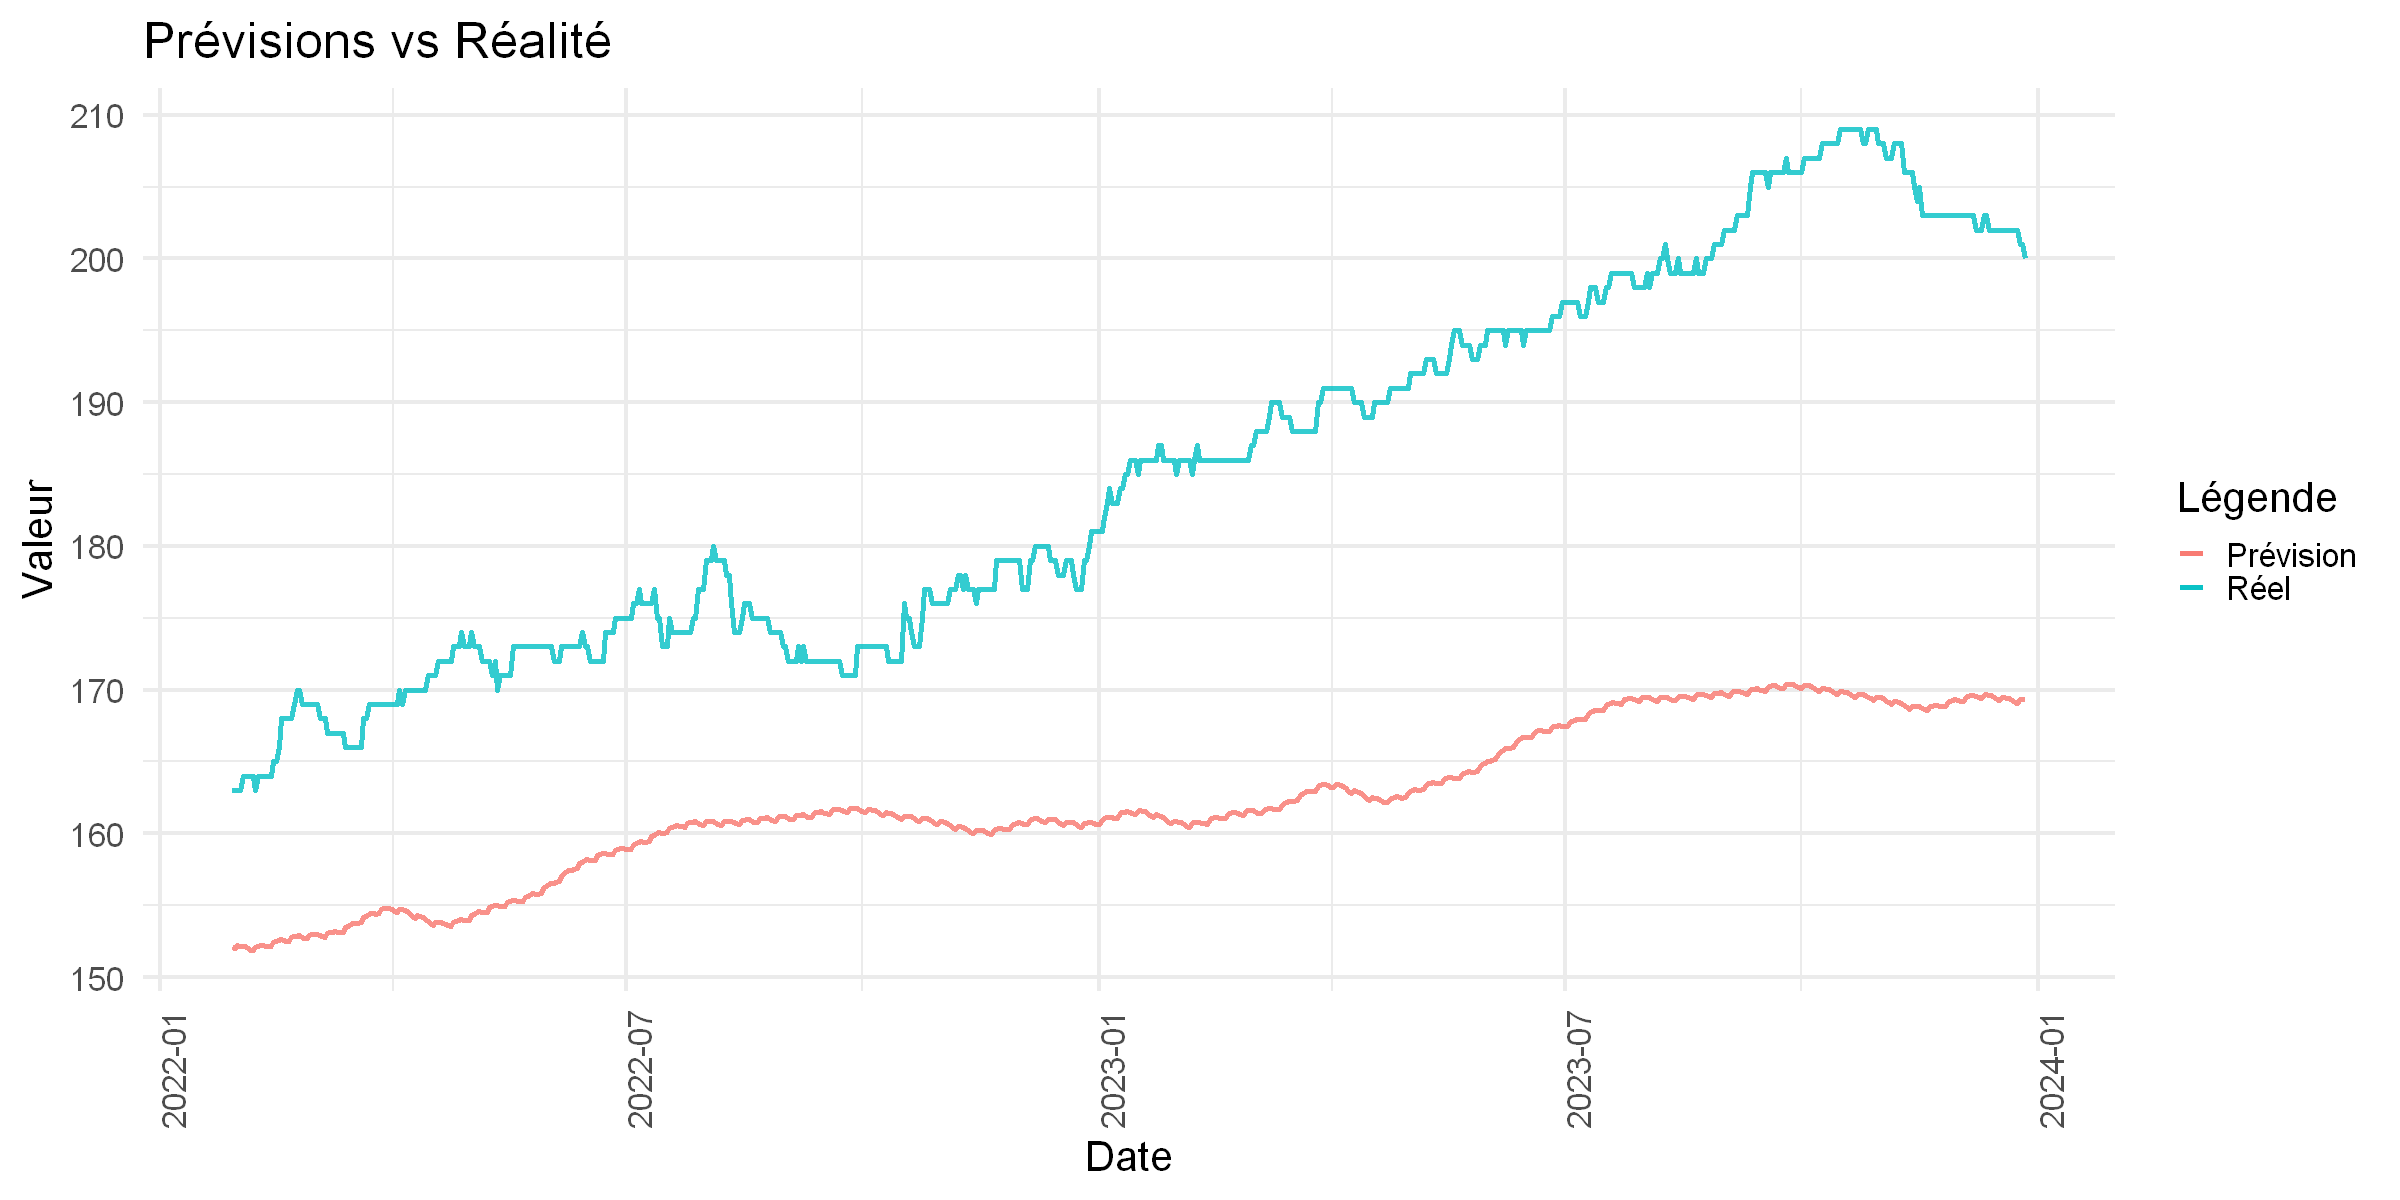

In [27]:
data_test$ds <- as.Date(data_test$ds)
data_test_forecast$ds <- as.Date(data_test_forecast$ds)

ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = data_test_forecast, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité",
       x = "Date",
       y = "Valeur",
       color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) # Rotation 

In [28]:
options(repr.plot.width=20, repr.plot.height=10)

# Conversion des dates dans les données de mf_forecast et data
data_test_forecast$ds <- as.POSIXct(data_test_forecast$ds)
data$date <- as.POSIXct(data$date)

# Tracer les graphiques avec ggplot2
plot1 = ggplot() +
  geom_line(data = data_test_forecast, aes(x = ds, y = yhat, color = "Prévisions"), size = 2) +
  geom_line(data = data, aes(x = date, y = nombre_employes_total, color = "Données réelles"), size = 2) +
  geom_ribbon(data = data_test_forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Intervalle de confiance"), alpha = 0.5) +
  labs(title = "Prévisions du modèle par défaut", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25) +
  scale_color_manual(values = c("Prévisions" = "blue", "Données réelles" = "orange")) +
  scale_fill_manual(values = c("Intervalle de confiance" = "lightblue")) +
  theme(legend.position = "bottom")  # Positionner la légende en bas

data_test$ds <- as.Date(data_test$ds)
data_test_forecast$ds <- as.Date(data_test_forecast$ds)

plot2 = ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = data_test_forecast, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité",
       x = "Date",
       y = "Valeur",
       color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) # Rotation 

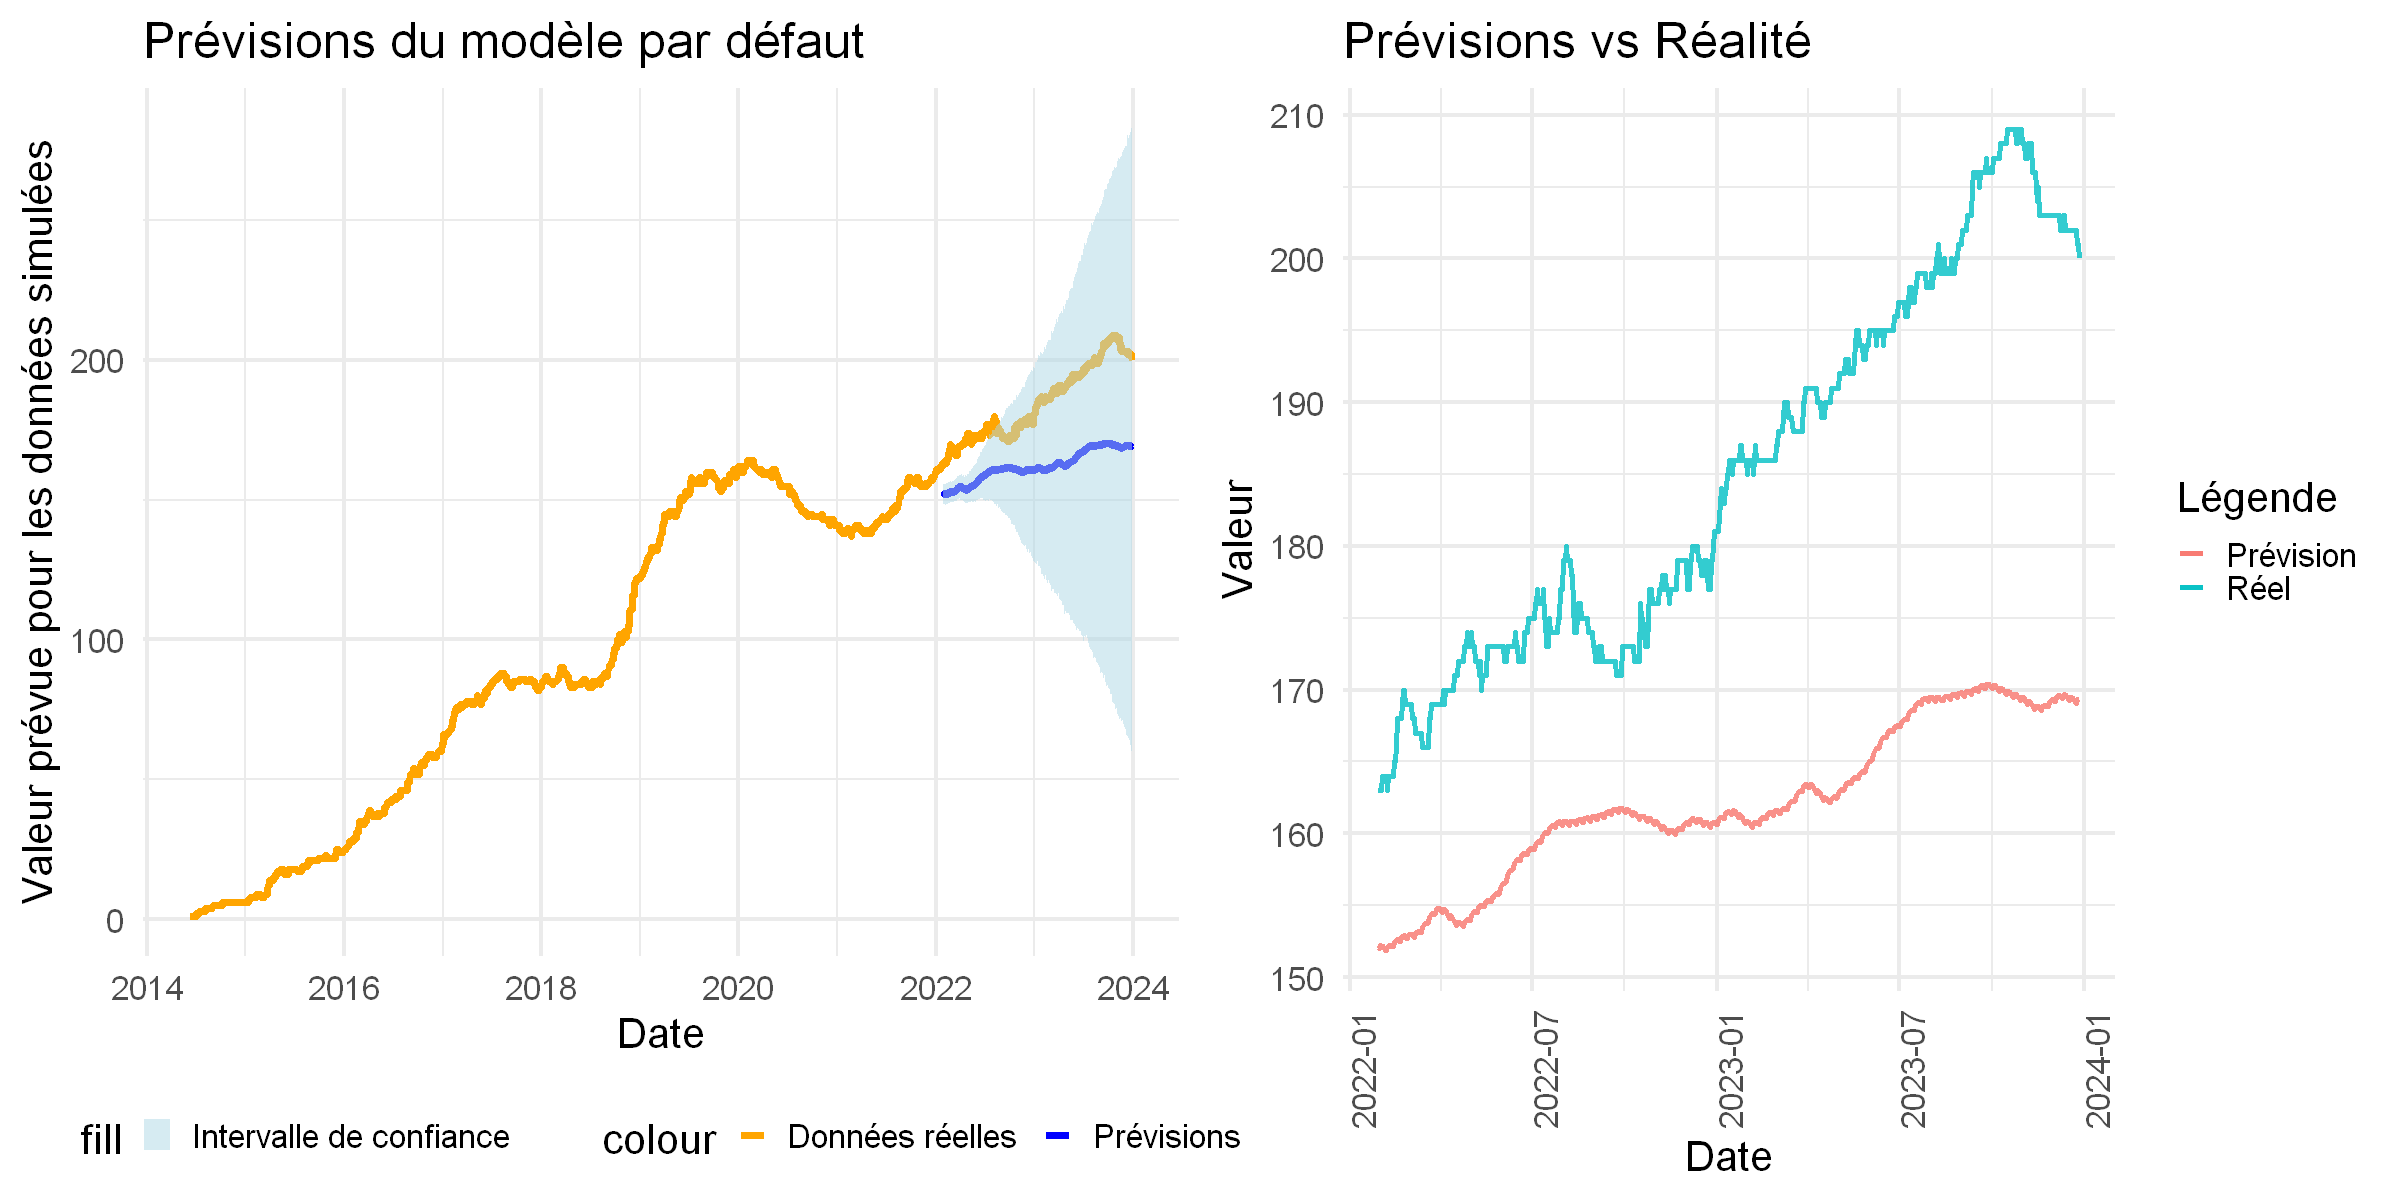

In [29]:
grid.arrange(plot1,plot2,nrow=1)

#### Evaluation de la précision (MAPE et RMSE)

In [30]:
mape = mean_absolute_percentage_error(data_test$y,data_test_forecast$yhat)
rmse = sqrt(mean((data_test$y - data_test_forecast$yhat)^2))

In [31]:
print(mape)
print(rmse)

[1] 12.10151
[1] 24.34291


La mape pour les prédictions est d'environ 12.10 %. Cela signifie que, en moyenne, les prédictions faites par le modèle ont une erreur absolue de 12.10 % par rapport aux valeurs réelles. Ce qui est relativement bon.

## Que se passe-t-il si l'on ajoute les jours fériés et les évenements au modèle ?

A faire.

### Importation des données des vacances en france pour la période 2010 2030

Les données importées proviennent du site $\href{https://public.opendatasoft.com/explore/dataset/jours-ouvres-week-end-feries-france-2010-a-2030/table/?flg=fr-fr&disjunctive.jour&disjunctive.statut&sort=-date}{opendatasoft}$

In [32]:
jours_feries <- read.csv("jours_feries_france.csv", sep = ";", header = TRUE, fileEncoding = "ISO-8859-1")

In [33]:
jours_feries %>% head(5)

Date       Année Jour.de.la.semaine Statut Code.du.jour Description        
1 01/01/2010 2010  vendredi           férié  5            Jour de l'an       
2 05/04/2010 2010  lundi              férié  1            Lundi de Pâques    
3 01/05/2010 2010  samedi             férié  6            Fête du Travail    
4 08/05/2010 2010  samedi             férié  6            Fête de la Victoire
5 13/05/2010 2010  jeudi              férié  4            Ascension          
  Jour.et.date
1 vendredi 1  
2 lundi 5     
3 samedi 1    
4 samedi 8    
5 jeudi 13

In [34]:
jours_feries <- jours_feries %>%
  mutate(Date = dmy(Date)) %>%
rename(date =`Date`, annee = `Année`, jour_semaine = `Jour.de.la.semaine`, status=`Statut`,
      code_jour = "Code.du.jour", description = `Description`, jour_date = `Jour.et.date`)

In [35]:
jours_feries %>% head(5)

date       annee jour_semaine status code_jour description         jour_date 
1 2010-01-01 2010  vendredi     férié  5         Jour de l'an        vendredi 1
2 2010-04-05 2010  lundi        férié  1         Lundi de Pâques     lundi 5   
3 2010-05-01 2010  samedi       férié  6         Fête du Travail     samedi 1  
4 2010-05-08 2010  samedi       férié  6         Fête de la Victoire samedi 8  
5 2010-05-13 2010  jeudi        férié  4         Ascension           jeudi 13

In [36]:
print(min(data_train$ds))
print(max(data_train$ds))

[1] "2014-06-09"
[1] "2022-01-28"


In [37]:
holidays = jours_feries %>% 
                filter((date >= min(data_train$ds)) & date <= max(data_train$ds)) %>% 
                select( c(date,description,jour_date)) %>% 
                rename(ds = `date`) %>%
                mutate(lower_window = 0, upper_window = 1)

In [38]:
holidays %>% head(5)

ds         description        jour_date   lower_window upper_window
1 2014-06-09 Lundi de Pentecôte lundi 9     0            1           
2 2014-07-14 Fête Nationale     lundi 14    0            1           
3 2014-08-15 Assomption         vendredi 15 0            1           
4 2014-11-01 Toussaint          samedi 1    0            1           
5 2014-11-11 Armistice 1918     mardi 11    0            1

In [39]:
holidays$description <- iconv(holidays$description, to = "UTF-8", sub = "byte")

holidays$description <- gsub("[^a-zA-Z0-9]", "", holidays$description)

holidays$description <- tolower(holidays$description)

In [40]:
holidays <- holidays %>% rename(holiday = description)

In [41]:
holidays = holidays %>% select(c(holiday,ds,lower_window,upper_window))

In [42]:
holidays %>% head(5)

holiday         ds         lower_window upper_window
1 lundidepentecte 2014-06-09 0            1           
2 ftenationale    2014-07-14 0            1           
3 assomption      2014-08-15 0            1           
4 toussaint       2014-11-01 0            1           
5 armistice1918   2014-11-11 0            1

#### Inclusion de l'effet du covid-19

En 2020 et 2021, la France a imposé trois périodes de confinement pour contenir la propagation du Covid-19 : du 17 mars au 11 mai 2020, du 30 octobre au 15 décembre 2020, et du 3 avril au 3 mai 2021.

In [43]:
library(dplyr)
library(lubridate)

# Création du DataFrame lockdowns
lockdowns <- data.frame(
  holiday = c('lockdown_1', 'lockdown_2', 'lockdown_3'),
  ds = as.Date(c('2020-03-17', '2020-10-30', '2021-04-03')),
  ds_upper = as.Date(c('2020-05-10', '2020-12-15', '2021-05-03'))
)

# Conversion en format de date si nécessaire
lockdowns$ds <- as.Date(lockdowns$ds)
lockdowns$ds_upper <- as.Date(lockdowns$ds_upper)

# Calcul de la colonne upper_window
lockdowns <- mutate(lockdowns, upper_window = as.numeric(difftime(ds_upper, ds, units = "days")))

lockdowns$lower_window <- 0
lockdowns  = lockdowns %>% select(c(holiday,ds,lower_window,upper_window))

In [44]:
lockdowns

holiday    ds         lower_window upper_window
1 lockdown_1 2020-03-17 0            54          
2 lockdown_2 2020-10-30 0            46          
3 lockdown_3 2021-04-03 0            30

In [45]:
lockdowns <- lockdowns %>% select(c(holiday,ds,lower_window,upper_window))

In [46]:
holidays = rbind(holidays,lockdowns)

In [47]:
holidays %>% tail(5)

holiday    ds         lower_window upper_window
83 nol        2021-12-25 0             1          
84 jourdelan  2022-01-01 0             1          
85 lockdown_1 2020-03-17 0            54          
86 lockdown_2 2020-10-30 0            46          
87 lockdown_3 2021-04-03 0            30

In [48]:
m_with_holidays = prophet(data_train, holidays = holidays,interval.width = 0.95)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.



In [49]:
m_with_holidays %>% head(5)

$growth
[1] "linear"

$changepoints
 [1] "2014-09-06 GMT" "2014-12-04 GMT" "2015-03-04 GMT" "2015-06-01 GMT"
 [5] "2015-08-29 GMT" "2015-11-26 GMT" "2016-02-24 GMT" "2016-05-23 GMT"
 [9] "2016-08-20 GMT" "2016-11-17 GMT" "2017-02-15 GMT" "2017-05-15 GMT"
[13] "2017-08-12 GMT" "2017-11-09 GMT" "2018-02-07 GMT" "2018-05-07 GMT"
[17] "2018-08-04 GMT" "2018-11-01 GMT" "2019-01-30 GMT" "2019-04-29 GMT"
[21] "2019-07-27 GMT" "2019-10-24 GMT" "2020-01-22 GMT" "2020-04-20 GMT"
[25] "2020-07-18 GMT"

$n.changepoints
[1] 25

$changepoint.range
[1] 0.8

$yearly.seasonality
[1] "auto"


In [50]:
future_with_holidays = m_with_holidays %>% make_future_dataframe(freq = "day",periods = nrow(data_test))

ds         yhat     yhat_lower yhat_upper
3483 2023-12-21 169.4005 57.64017   269.6153  
3484 2023-12-22 169.2536 57.18474   272.6135  
3485 2023-12-23 169.1528 55.44298   271.6496  
3486 2023-12-24 169.0837 54.34891   271.3144  
3487 2023-12-25 169.3212 56.74974   271.4236  
3488 2023-12-26 169.3482 55.17108   274.0477  
3489 2023-12-27 169.3583 55.75509   272.5741

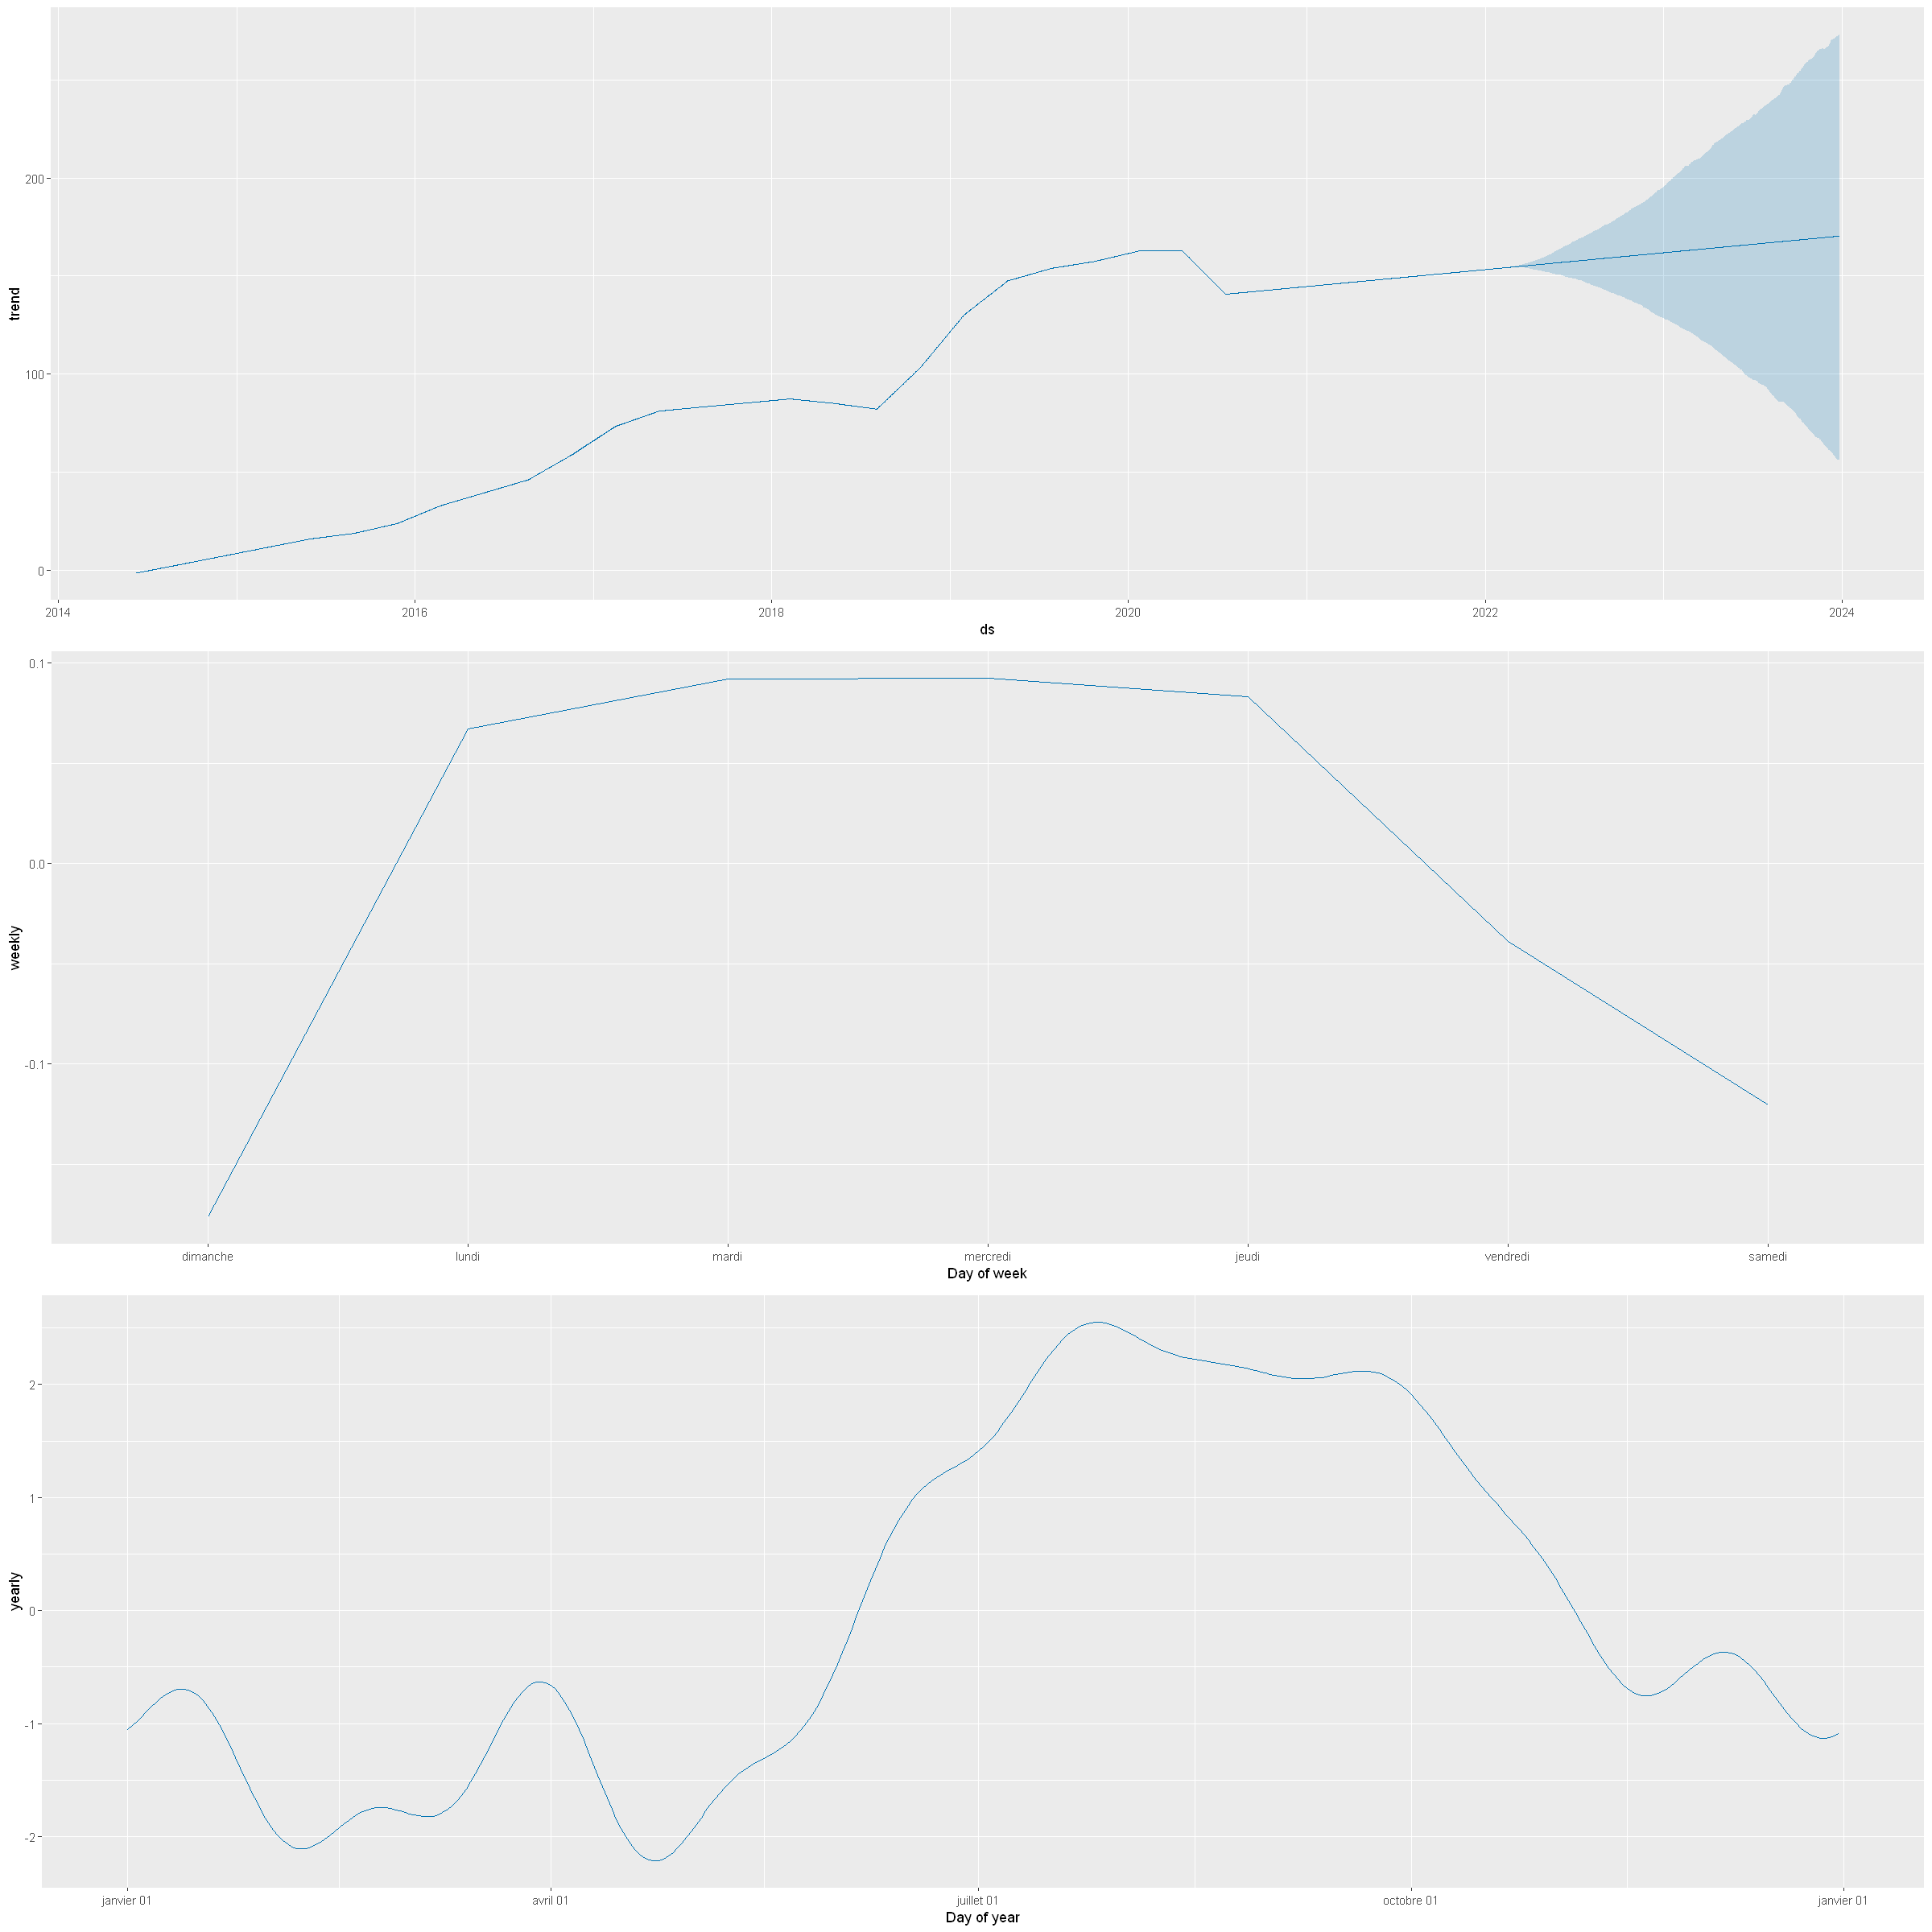

In [51]:
forecast_with_holidays = m %>% predict(future_with_holidays)
forecast_with_holidays[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]%>% tail(7)

# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=20)

prophet_plot_components(m, forecast_with_holidays)

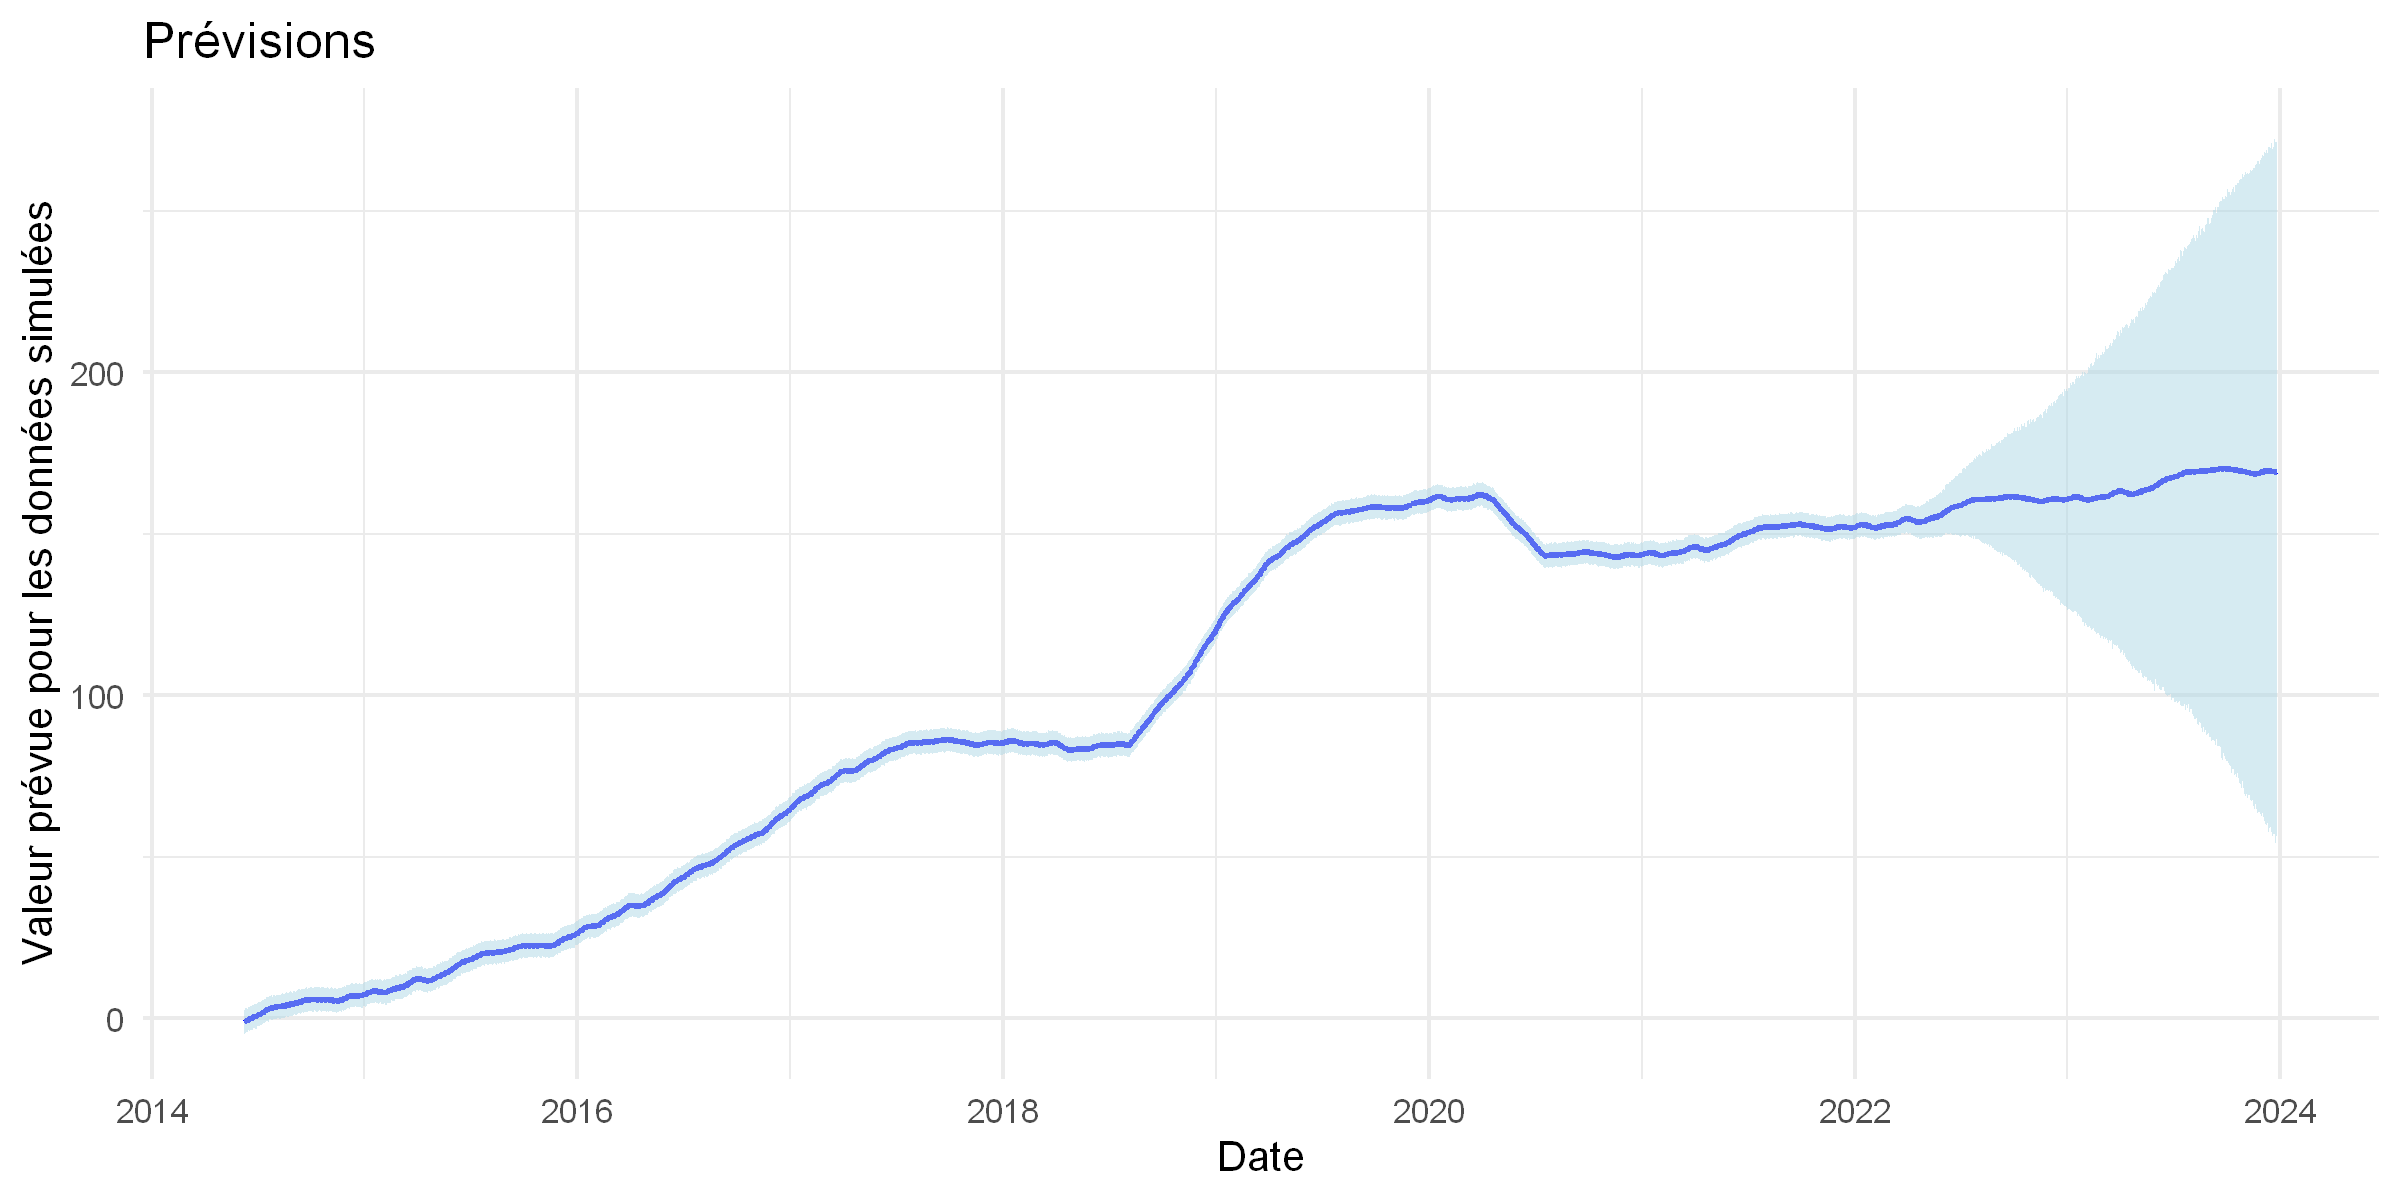

In [52]:
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=10)
ggplot() +
  geom_line(data = forecast_with_holidays, aes(x = ds, y = yhat), color = "blue", size = 1.5) +
  geom_ribbon(data = forecast_with_holidays, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions",
       x = "Date",
       y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)

In [53]:
data_test_forecast_with_holidays = m_with_holidays %>% predict(data_test)
data_test_forecast_with_holidays[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')] %>% tail(7)

ds         yhat     yhat_lower yhat_upper
692 2023-12-21 170.6274 -42.85847  374.2872  
693 2023-12-22 170.4760 -40.90897  374.8717  
694 2023-12-23 170.3916 -41.31065  373.1291  
695 2023-12-24 170.3069 -41.48264  374.0605  
696 2023-12-25 170.5186 -42.39413  374.4441  
697 2023-12-26 170.5190 -41.16292  378.0023  
698 2023-12-27 170.5237 -40.97371  375.0340

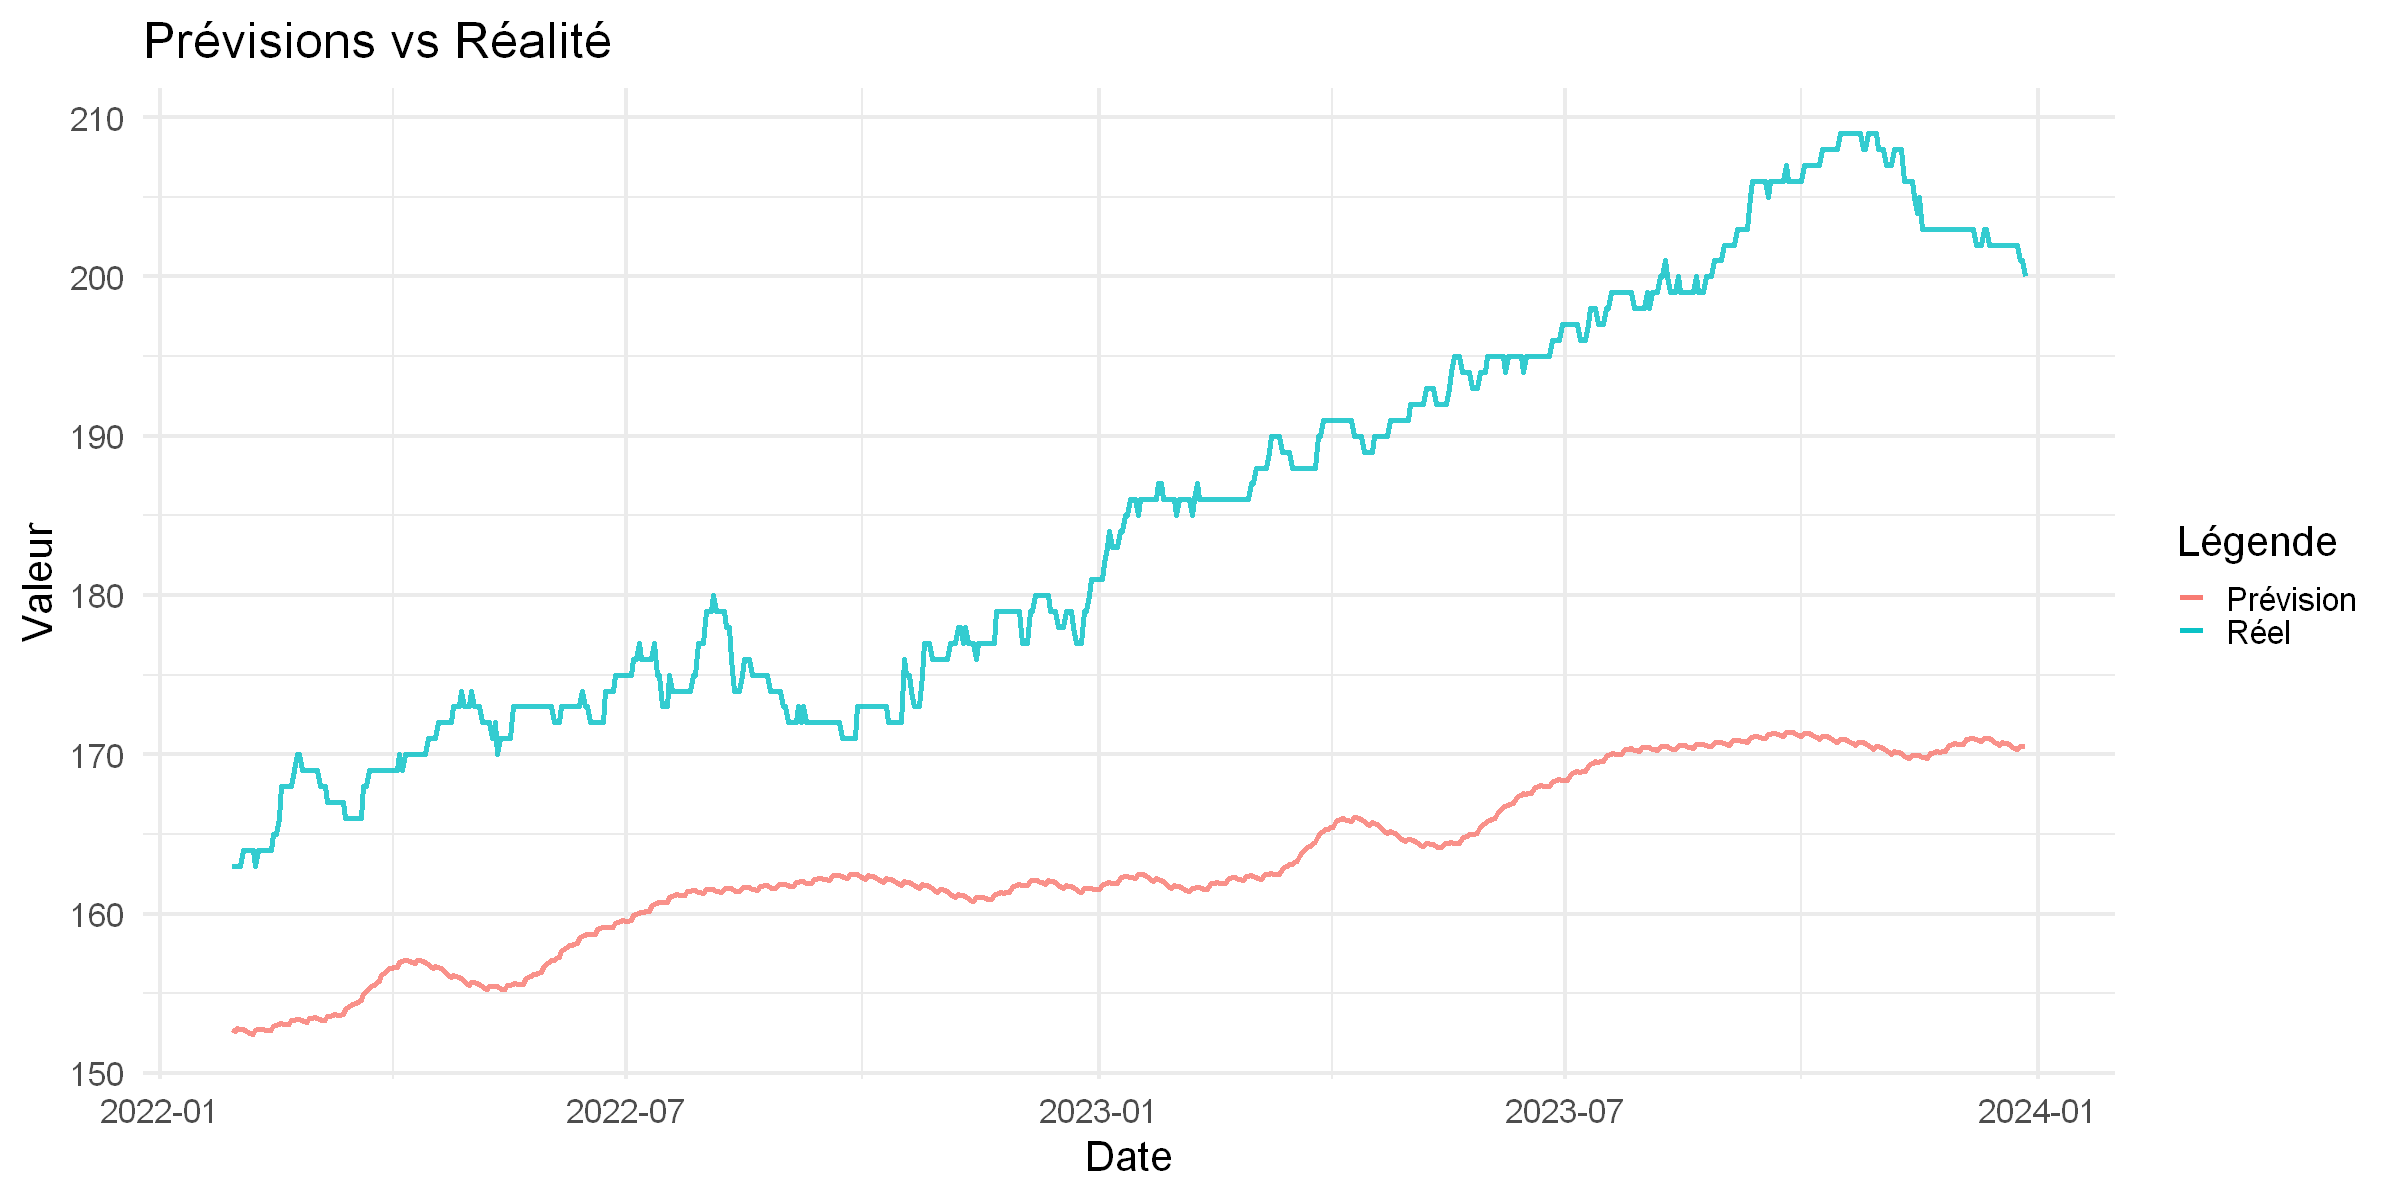

In [54]:
data_test$ds <- as.Date(data_test$ds)
data_test_forecast_with_holidays$ds <- as.Date(data_test_forecast_with_holidays$ds)


prophet_predict <- ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = data_test_forecast_with_holidays, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité", x = "Date", y = "Valeur", color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right")


print(prophet_predict)

In [55]:
options(repr.plot.width=20, repr.plot.height=10)

# Conversion des dates dans les données de mf_forecast et data
data_test_forecast_with_holidays$ds <- as.POSIXct(data_test_forecast_with_holidays$ds)
data$date <- as.POSIXct(data$date)

# Tracer les graphiques avec ggplot2
plot3 = ggplot() +
  geom_line(data = data_test_forecast_with_holidays, aes(x = ds, y = yhat, color = "Prévisions"), size = 2) +
  geom_line(data = data, aes(x = date, y = nombre_employes_total, color = "Données réelles"), size = 2) +
  geom_ribbon(data = data_test_forecast_with_holidays, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Intervalle de confiance"), alpha = 0.5) +
  labs(title = "Prévisions du modèle par défaut", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25) +
  scale_color_manual(values = c("Prévisions" = "blue", "Données réelles" = "orange")) +
  scale_fill_manual(values = c("Intervalle de confiance" = "lightblue")) +
  theme(legend.position = "bottom")  # Positionner la légende en bas

data_test$ds <- as.Date(data_test$ds)
data_test_forecast_with_holidays$ds <- as.Date(data_test_forecast_with_holidays$ds)

plot4 = ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = data_test_forecast_with_holidays, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité",
       x = "Date",
       y = "Valeur",
       color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) # Rotation 

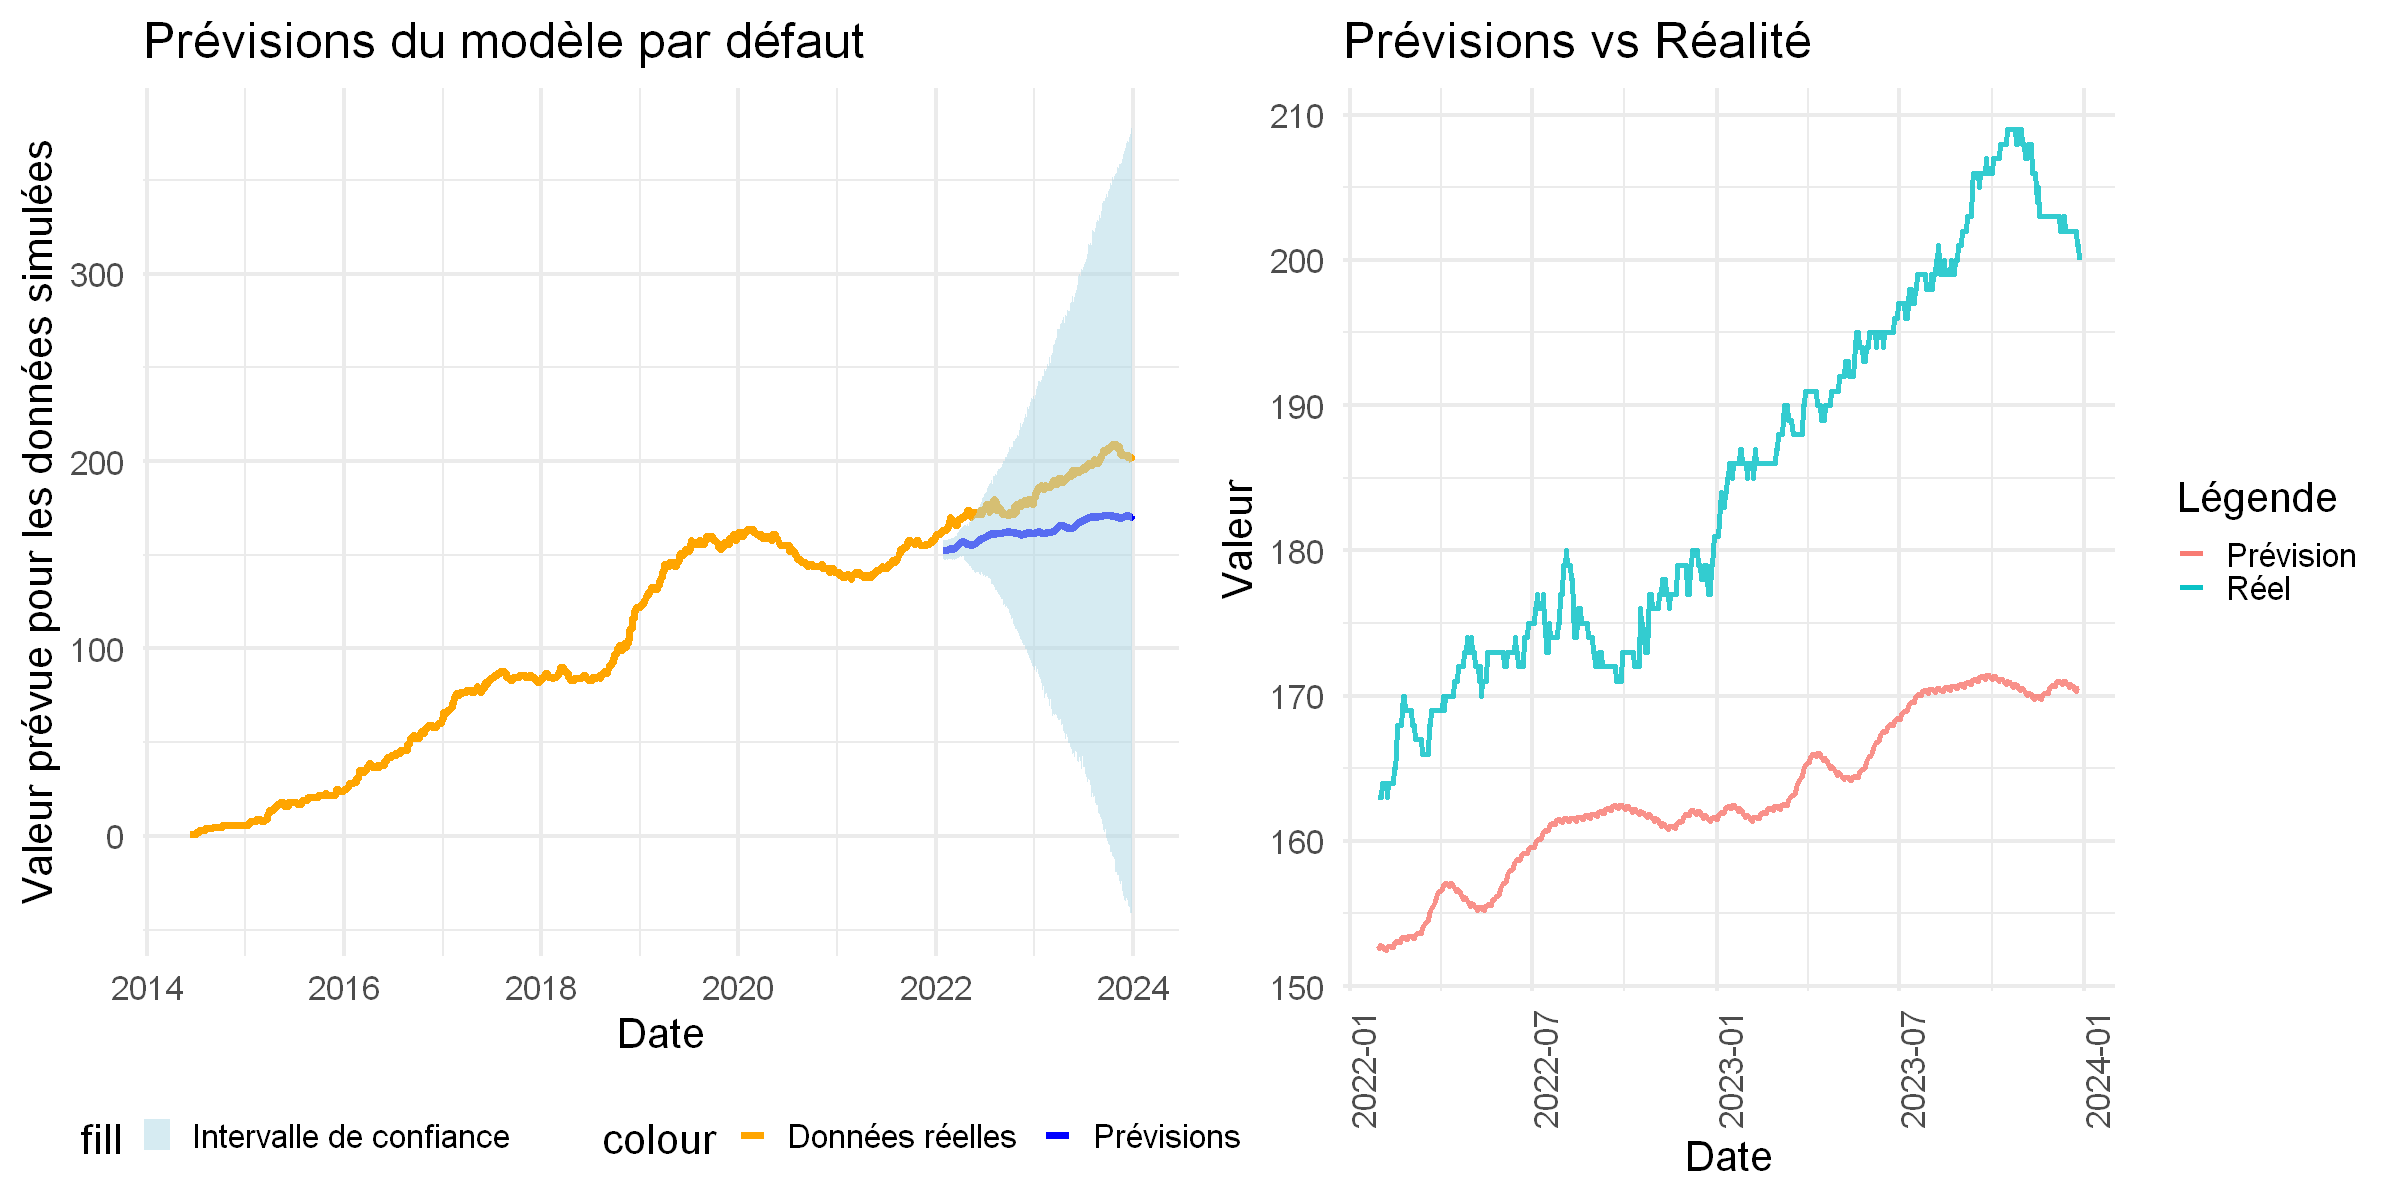

In [56]:
grid.arrange(plot3,plot4,nrow=1)

In [57]:
mape = mean_absolute_percentage_error(data_test$y,data_test_forecast_with_holidays$yhat)
rmse = sqrt(mean((data_test$y - data_test_forecast_with_holidays$yhat)^2))

In [58]:
print(mape)
print(rmse)

[1] 11.55366
[1] 23.34539


La mape a légèrement baissée. Ce qui signigifie que les holidays apportent de meilleures précisions pour le modèle. La prochaine question à laquelle on se pose serait de voir quels sont les meilleurs hyperparamètres pour bien ajuster le modèle. Pour les trouver, nous effectuerons le tunning du modèle.

En plus des jours fériés, il existe de nombreux autres hyperparamètres qui aident à optimiser le modèle Prophet.

- Jours fériés
- Changepoints : (n_changepoints, changepoint_prior_scale)
- Mode de saisonnalité
- holiday_prior_scale
- Saisonnalités avec order de Fourier
- Nous avons ajouté des jours fériés à notre modèle et observé leur effet.

- **n_changepoints** représente le nombre de changements dans les données. Le modèle Prophet les détecte automatiquement. Par défaut, sa valeur est de 25, répartis de manière uniforme dans les 80 % initiaux de la série temporelle. Modifier n_changepoints peut ajouter de la valeur au modèle.
- **changepoint_prior_scale** indique à quel point les changements peuvent être flexibles. En d'autres termes, dans quelle mesure les changements peuvent s'adapter aux données. Si vous le réglez à une valeur élevée, il sera plus flexible, mais vous risquez de surajuster. Par défaut, ce paramètre est défini sur 0,05.
- **seasonality_mode** : Il existe 2 types de modes de saisonnalité. Additif et multiplicatif. Par défaut, Prophet ajuste des saisonnalités additives, ce qui signifie que l'effet de la saisonnalité est ajouté à la tendance pour obtenir la prévision. Prophet peut modéliser la saisonnalité multiplicatrice en définissant seasonality_mode='multiplicative' dans le modèle.
- **holiday_prior_scale**, tout comme changepoint_prior_scale, est utilisé pour lisser l'effet des jours fériés. Par défaut, sa valeur est de 10, ce qui fournit très peu de régularisation. Réduire ce paramètre atténue les effets des jours fériés.

Par défaut, Prophet utilise un ordre de Fourier de 3 pour la saisonnalité hebdomadaire et de 10 pour la saisonnalité annuelle.
Maintenant, nous allons effectuer l'optimisation des hyperparamètres en utilisant parametergrid. parametergrid va créer toutes les combinaisons de paramètres possibles et testera la prédiction du modèle en utilisant chaque combinaison.

## Tunning des hyperparamètres

In [59]:
#growth <- as.factor(c("linear","flat","logistic"))
seasonality_mode <- c("multiplicative", "additive")
changepoint_prior_scale <- c(0.1, 0.2, 0.3, 0.4, 0.5)
holidays_prior_scale <- c(0.1, 0.2, 0.3, 0.4, 0.5)
n_changepoints <- c(100, 150, 200)
#seasonality_prior_scale <- c(0.01, 0.1, 1.0, 10.0)

param_grid <- expand.grid(#growth = growth,
    seasonality_mode = seasonality_mode,
                           changepoint_prior_scale = changepoint_prior_scale,
                           holidays_prior_scale = holidays_prior_scale,
                           n_changepoints = n_changepoints,
                           #seasonality_prior_scale = seasonality_prior_scale,
                           weekly_seasonality = TRUE,
                           daily_seasonality = TRUE,
                           yearly_seasonality = TRUE
                          )

# le nombre total de modèles possibles
cat("Total Possible Models:", nrow(param_grid), "\n")

Total Possible Models: 150 


In [60]:
# les premières lignes de la grille de paramètres
head(param_grid)

seasonality_mode changepoint_prior_scale holidays_prior_scale n_changepoints
1 multiplicative   0.1                     0.1                  100           
2 additive         0.1                     0.1                  100           
3 multiplicative   0.2                     0.1                  100           
4 additive         0.2                     0.1                  100           
5 multiplicative   0.3                     0.1                  100           
6 additive         0.3                     0.1                  100           
  weekly_seasonality daily_seasonality yearly_seasonality
1 TRUE               TRUE              TRUE              
2 TRUE               TRUE              TRUE              
3 TRUE               TRUE              TRUE              
4 TRUE               TRUE              TRUE              
5 TRUE               TRUE              TRUE              
6 TRUE               TRUE              TRUE

In [61]:
# Initialiser une structure de données pour stocker les paramètres et les métriques
model_parameters <- data.frame(MAPE = numeric(), Parameters = character())

# Itérer à travers la grille de paramètres
for (i in 1:nrow(param_grid)) {
  # Récupérer les paramètres pour cette itération
  p <- param_grid[i, ]
  
  # Créer et entraîner le modèle Prophet avec les paramètres spécifiés
m <- prophet(data_train, 
             holidays = holidays,
             #growth = as.character(p$growth),
             changepoint.prior.scale = p$changepoint_prior_scale,
             holidays.prior.scale = p$holidays_prior_scale,
             seasonality.prior.scale = p$seasonality_prior_scale,
             #seasonality.mode = p$seasonality_mode,
             weekly.seasonality = TRUE,
             daily.seasonality = TRUE,
             yearly.seasonality = TRUE)
  
   # Générer les prédictions pour les données de test
  forecast <- predict(m, data_test)
  
  # Calculer le MAPE
  MAPE <- mean_absolute_percentage_error(data_test$y, forecast$yhat)
  
  # Afficher le MAPE
  cat("Mean Absolute Percentage Error(MAPE):", MAPE, "\n")
  
  # Ajouter le MAPE et les paramètres à la structure de données
  model_parameters <- rbind(model_parameters, data.frame(MAPE = MAPE, Parameters = paste(p, collapse = ", ")))
}

# Afficher les résultats
print(model_parameters %>% head(5))

Mean Absolute Percentage Error(MAPE): 11.82552 
Mean Absolute Percentage Error(MAPE): 11.82552 
Mean Absolute Percentage Error(MAPE): 12.03526 
Mean Absolute Percentage Error(MAPE): 12.03526 
Mean Absolute Percentage Error(MAPE): 12.10323 
Mean Absolute Percentage Error(MAPE): 12.10323 
Mean Absolute Percentage Error(MAPE): 12.07864 
Mean Absolute Percentage Error(MAPE): 12.07864 
Mean Absolute Percentage Error(MAPE): 12.12482 
Mean Absolute Percentage Error(MAPE): 12.12482 
Mean Absolute Percentage Error(MAPE): 11.86044 
Mean Absolute Percentage Error(MAPE): 11.86044 
Mean Absolute Percentage Error(MAPE): 12.04977 
Mean Absolute Percentage Error(MAPE): 12.04977 
Mean Absolute Percentage Error(MAPE): 12.08968 
Mean Absolute Percentage Error(MAPE): 12.08968 
Mean Absolute Percentage Error(MAPE): 12.12775 
Mean Absolute Percentage Error(MAPE): 12.12775 
Mean Absolute Percentage Error(MAPE): 12.12604 
Mean Absolute Percentage Error(MAPE): 12.12604 
Mean Absolute Percentage Error(MAPE): 11

Le meilleur modèle est dans ce cas :

Traitement trop long.$\newline$
Utiliser **system.time({})** pour voir le temps de traitement

In [62]:
model_parameters[which(model_parameters$MAPE == min(model_parameters$MAPE)),]

MAPE     Parameters                             
161 11.75489 1, 0.1, 0.2, 100, 0.1, TRUE, TRUE, TRUE
162 11.75489 2, 0.1, 0.2, 100, 0.1, TRUE, TRUE, TRUE
211 11.75489 1, 0.1, 0.2, 150, 0.1, TRUE, TRUE, TRUE
212 11.75489 2, 0.1, 0.2, 150, 0.1, TRUE, TRUE, TRUE
261 11.75489 1, 0.1, 0.2, 200, 0.1, TRUE, TRUE, TRUE
262 11.75489 2, 0.1, 0.2, 200, 0.1, TRUE, TRUE, TRUE

Dans les détails, il s'agit du modèle avec les paramètres :
- **seasonality_mode** = "multiplicative" ou "additive"
- **changepoint_prior_scale** = 0.1
- **holidays_prior_scale** = 0.2
- **seasonality.prior.scale** = 0.1

### Modèle final

In [61]:
model_final <- prophet(data_train, 
             holidays = holidays,
             changepoint.prior.scale = 0.1,
             holidays.prior.scale = 0.2,
             #changepoint.range = 0.8,
             seasonality.prior.scale = 0.1,
             seasonality.mode = "multiplicative",
             weekly.seasonality = TRUE,
             daily.seasonality = TRUE,
             yearly.seasonality = TRUE,
             interval.width=0.95)

In [62]:
mf_future_dates = model_final %>% make_future_dataframe(freq = "day",periods = nrow(data_test))

In [63]:
forecast = predict(model_final,data_test)

In [64]:
mf_forecast = model_final %>% predict(mf_future_dates)

In [65]:
mean_absolute_percentage_error(data_test$y,forecast$yhat)
sqrt(mean((data_test$y - forecast$yhat)^2))

[1] 12.29535

[1] 24.63793

ds         yhat      yhat_lower yhat_upper
1 2014-06-09 0.7659506 -3.271496  4.792831  
2 2014-06-10 0.8115780 -3.527736  4.908923  
3 2014-06-11 0.8551450 -3.445118  4.945466  
4 2014-06-12 0.8997322 -3.274203  5.077883  
5 2014-06-13 0.9435223 -3.501888  5.023687  
6 2014-06-14 0.9876471 -3.227119  5.241711  
7 2014-06-15 1.0319424 -3.047924  5.127085

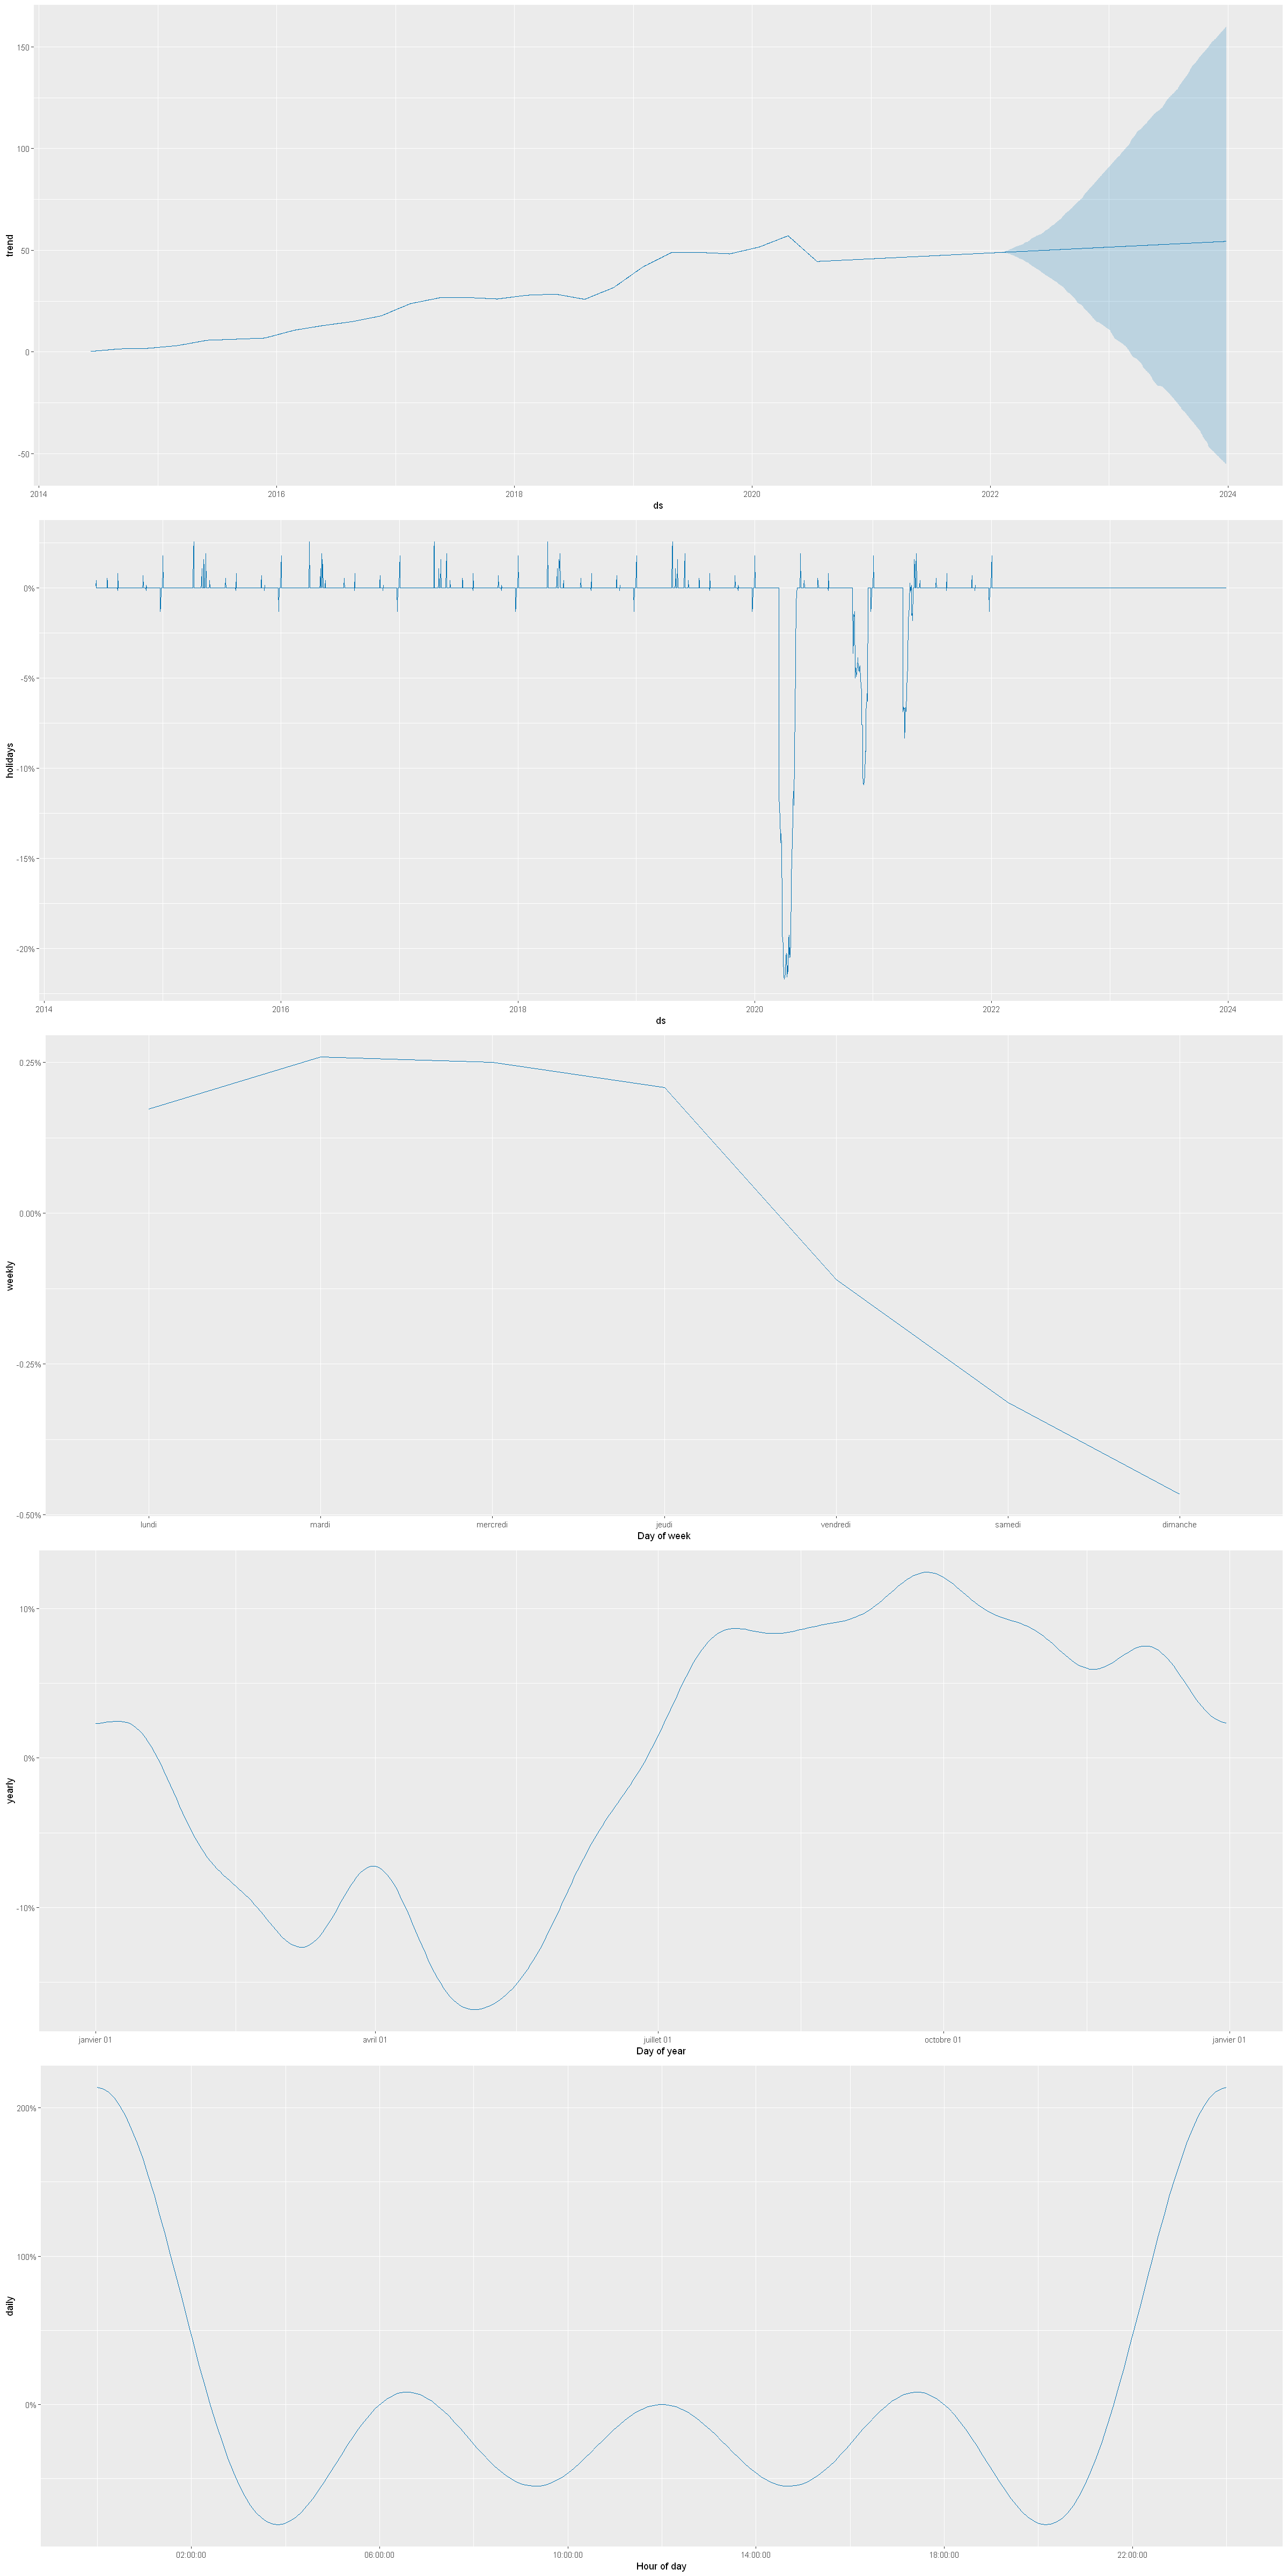

In [66]:
mf_forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')]%>% head(7)
# Spécification de la taille du graphique
options(repr.plot.width=20, repr.plot.height=40)
prophet_plot_components(model_final, mf_forecast,weekly_start = 1,render_plot = T)

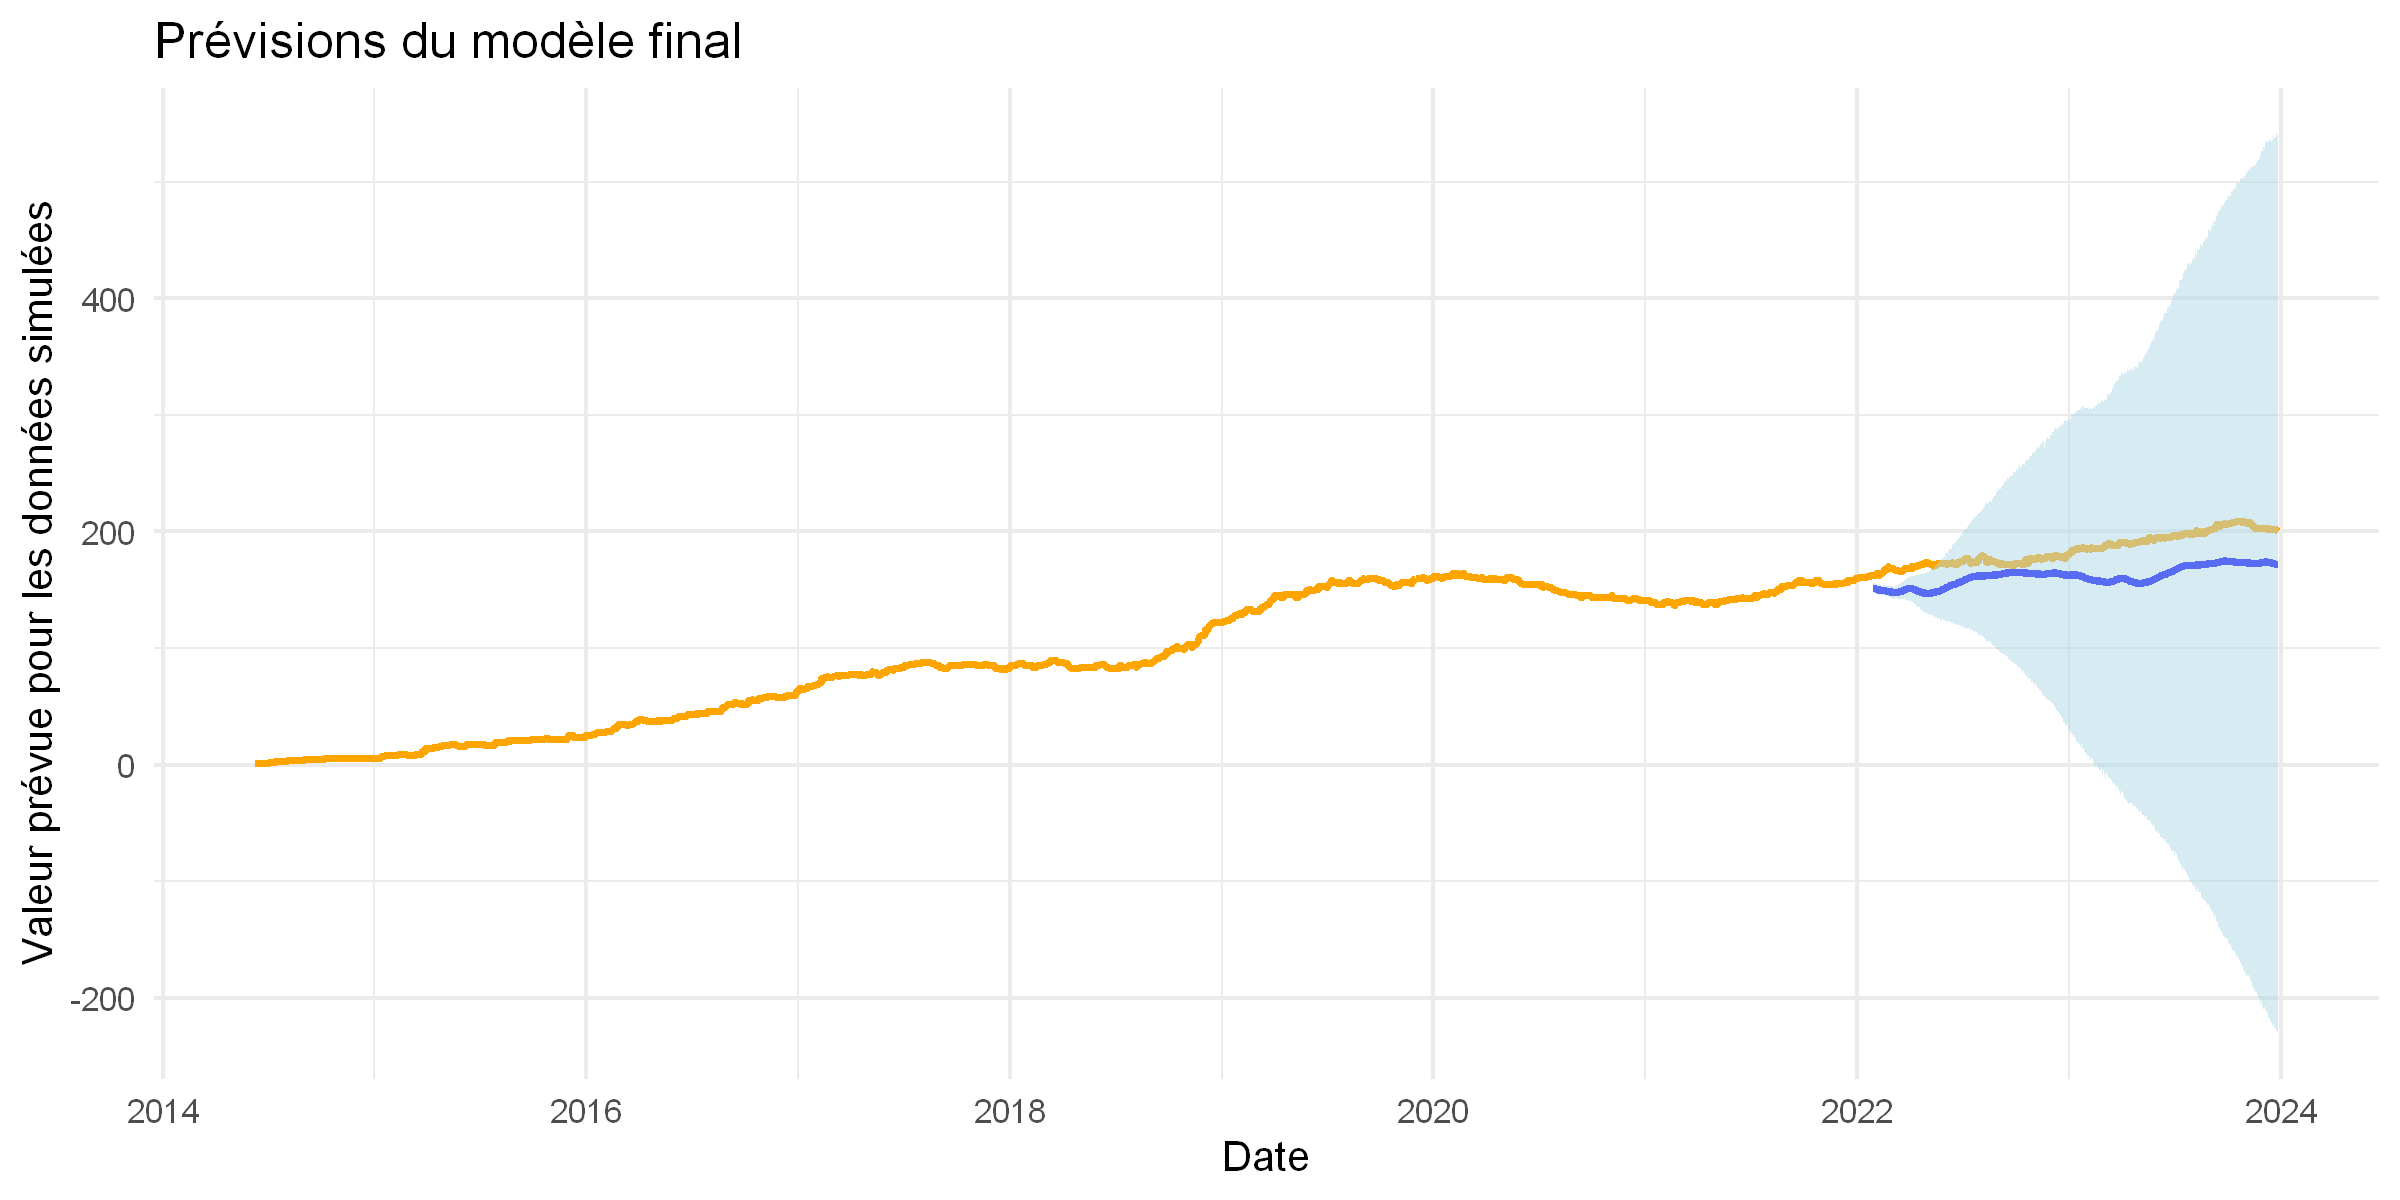

In [67]:
options(repr.plot.width=20, repr.plot.height=10)
# Conversion des dates dans les données de mf_forecast et data
forecast$ds <- as.POSIXct(forecast$ds)
data$date <- as.POSIXct(data$date)

# Tracer les graphiques avec ggplot2
ggplot() +
  geom_line(data = forecast, aes(x = ds, y = yhat), color = "blue", size = 2) +
  geom_line(data = data, aes(x = date, y = nombre_employes_total), color = "orange", size = 2) +
  geom_ribbon(data = forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.5) +
  labs(title = "Prévisions du modèle final", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25)


In [68]:
mf_data_test_forecast = model_final %>% predict(data_test)
mf_data_test_forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')] %>% tail(7)

ds         yhat     yhat_lower yhat_upper
692 2023-12-21 172.7442 -173.4509  584.5255  
693 2023-12-22 172.4384 -175.2984  585.3764  
694 2023-12-23 172.2047 -172.5866  587.8856  
695 2023-12-24 172.0104 -175.7128  583.9517  
696 2023-12-25 172.2596 -178.2953  587.7259  
697 2023-12-26 172.2232 -177.6493  589.1548  
698 2023-12-27 172.1510 -178.8884  588.9366

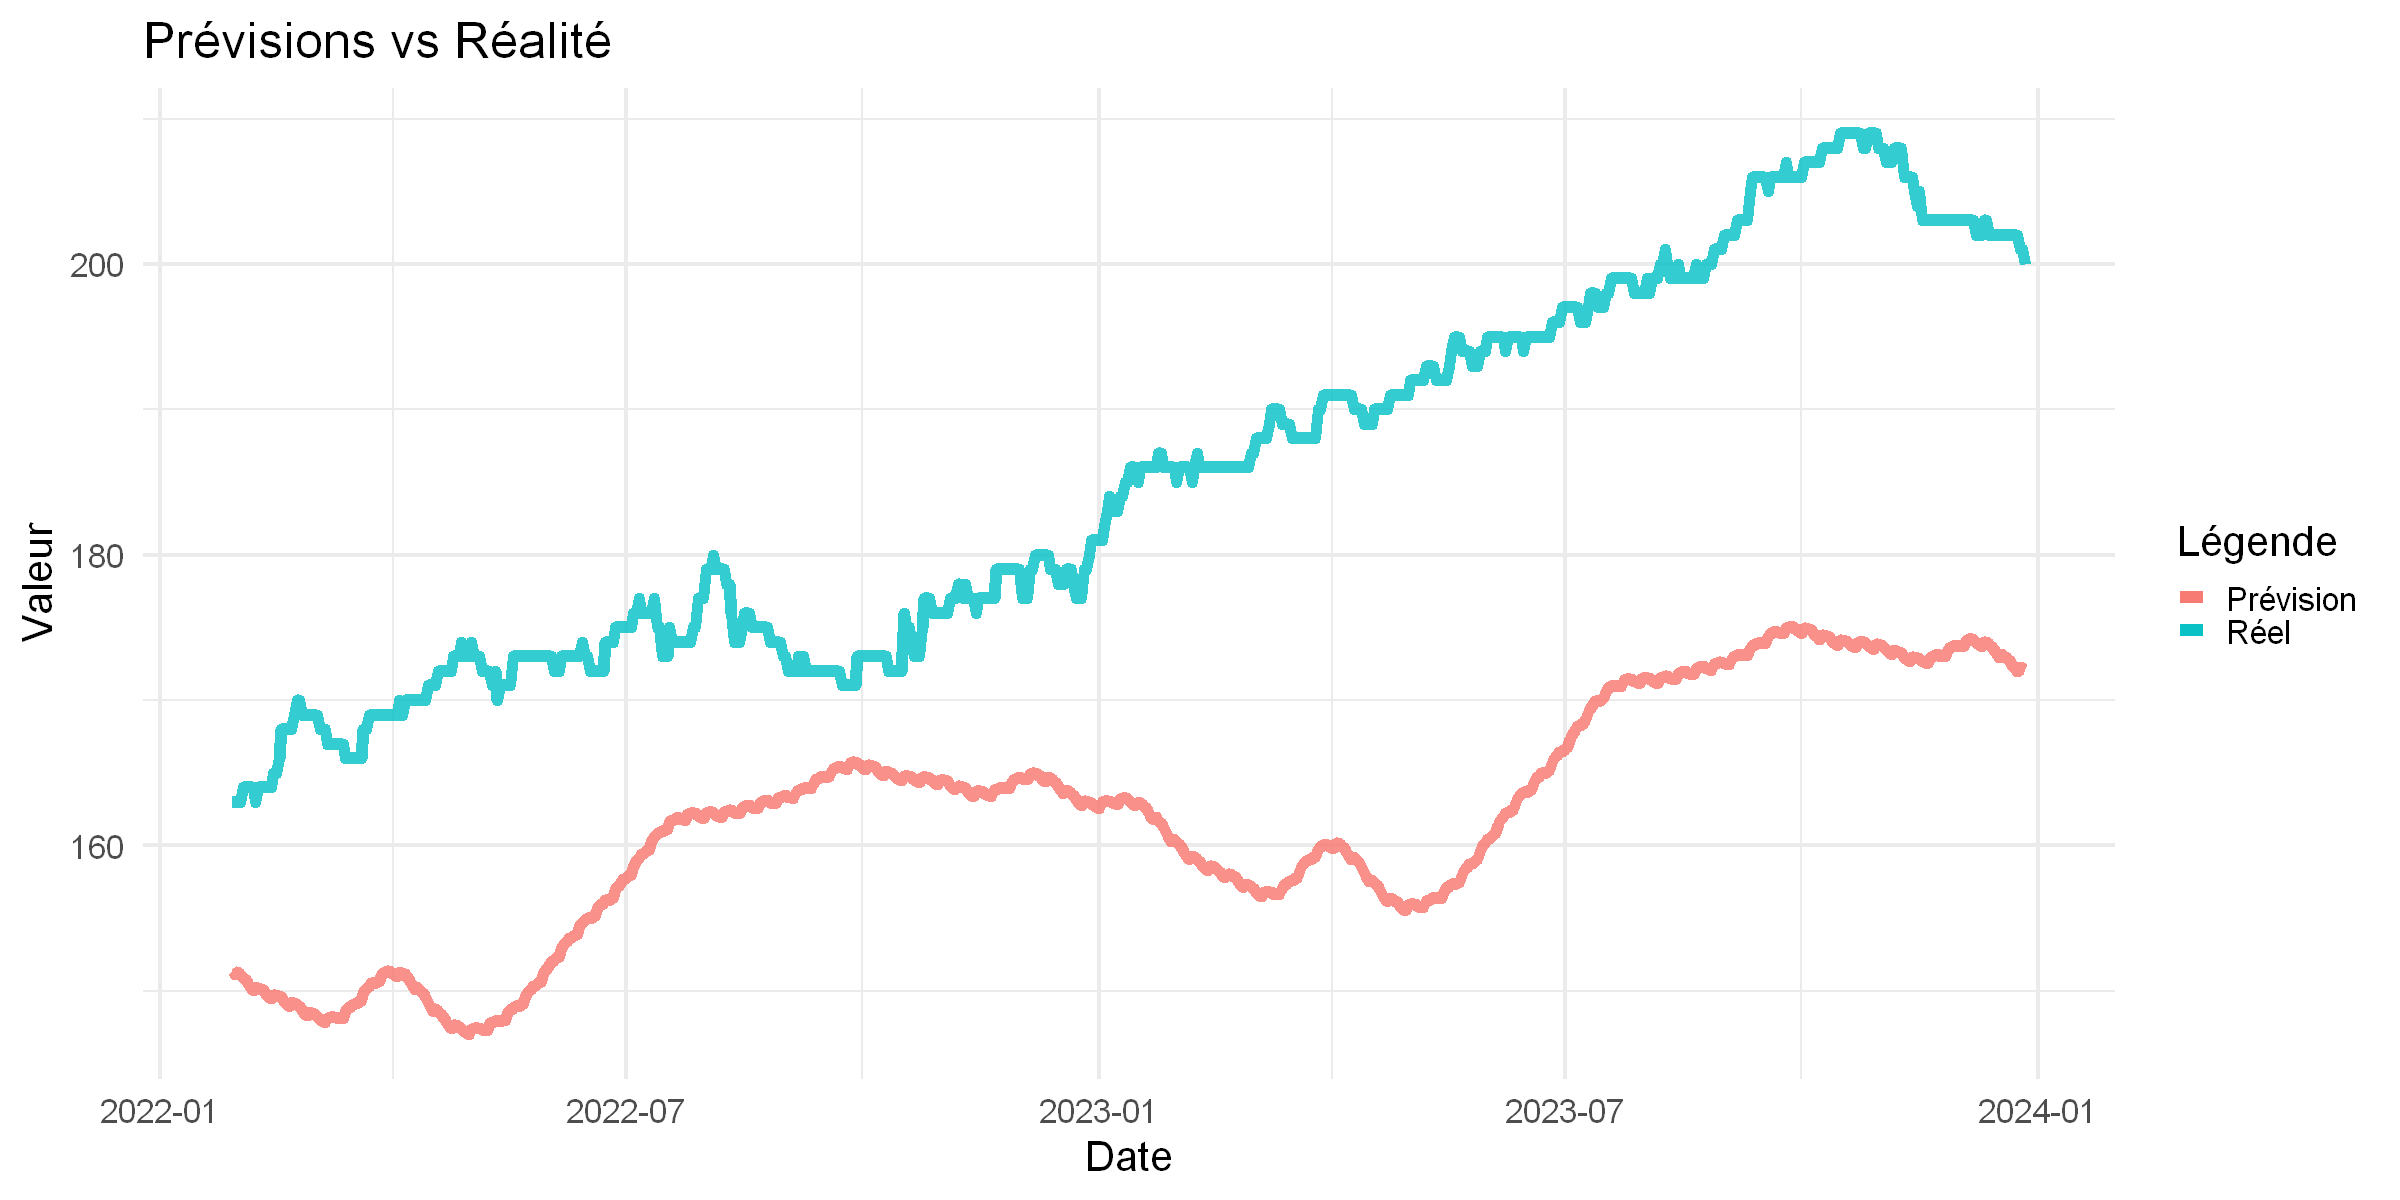

In [69]:

data_test$ds <- as.Date(data_test$ds)
mf_data_test_forecast$ds <- as.Date(mf_data_test_forecast$ds)


mf_prophet_predict <- ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", size = 3.5, alpha = 0.8) +
  geom_line(data = mf_data_test_forecast, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", size = 3.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité",
       x = "Date",
       y = "Valeur",
       color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right")

print(mf_prophet_predict)


In [70]:
options(repr.plot.width=20, repr.plot.height=10)

# Conversion des dates dans les données de mf_forecast et data
data_test_forecast$ds <- as.POSIXct(data_test_forecast$ds)
data$date <- as.POSIXct(data$date)

# Tracer les graphiques avec ggplot2
plot1 = ggplot() +
  geom_line(data = data_test_forecast, aes(x = ds, y = yhat, color = "Prévisions"), size = 2) +
  geom_line(data = data, aes(x = date, y = nombre_employes_total, color = "Données réelles"), size = 2) +
  geom_ribbon(data = data_test_forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper, fill = "Intervalle de confiance"), alpha = 0.5) +
  labs(title = "Prévisions du modèle par défaut", x = "Date", y = "Valeur prévue pour les données simulées") +
  theme_minimal(base_size = 25) +
  scale_color_manual(values = c("Prévisions" = "blue", "Données réelles" = "orange")) +
  scale_fill_manual(values = c("Intervalle de confiance" = "lightblue")) +
  theme(legend.position = "bottom")  # Positionner la légende en bas

data_test$ds <- as.Date(data_test$ds)
data_test_forecast$ds <- as.Date(data_test_forecast$ds)

plot2 = ggplot() +
  geom_line(data = data_test, aes(x = ds, y = y, color = "Réel"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  geom_line(data = data_test_forecast, aes(x = ds, y = yhat, color = "Prévision"), linetype = "solid", linewidth = 1.5, alpha = 0.8) +
  labs(title = "Prévisions vs Réalité",
       x = "Date",
       y = "Valeur",
       color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) # Rotation 

In [71]:
mf_data_test_forecast[1,]

ds         trend    armistice1918 armistice1918_lower armistice1918_upper
1 2022-01-29 48.88566 0             0                   0                  
  ascension ascension_lower ascension_upper assomption assomption_lower ⋯
1 0         0               0               0          0                ⋯
  yearly_lower yearly_upper additive_terms additive_terms_lower
1 -0.03564997  -0.03564997  0              0                   
  additive_terms_upper yhat_lower yhat_upper trend_lower trend_upper yhat    
1 0                    147.2314   155.8444   48.88566    48.88566    151.4301

In [72]:
data_test[1,]

ds         y  
2792 2022-01-29 163

In [73]:
data_train[nrow(data_train),]

ds         y  
2791 2022-01-28 163

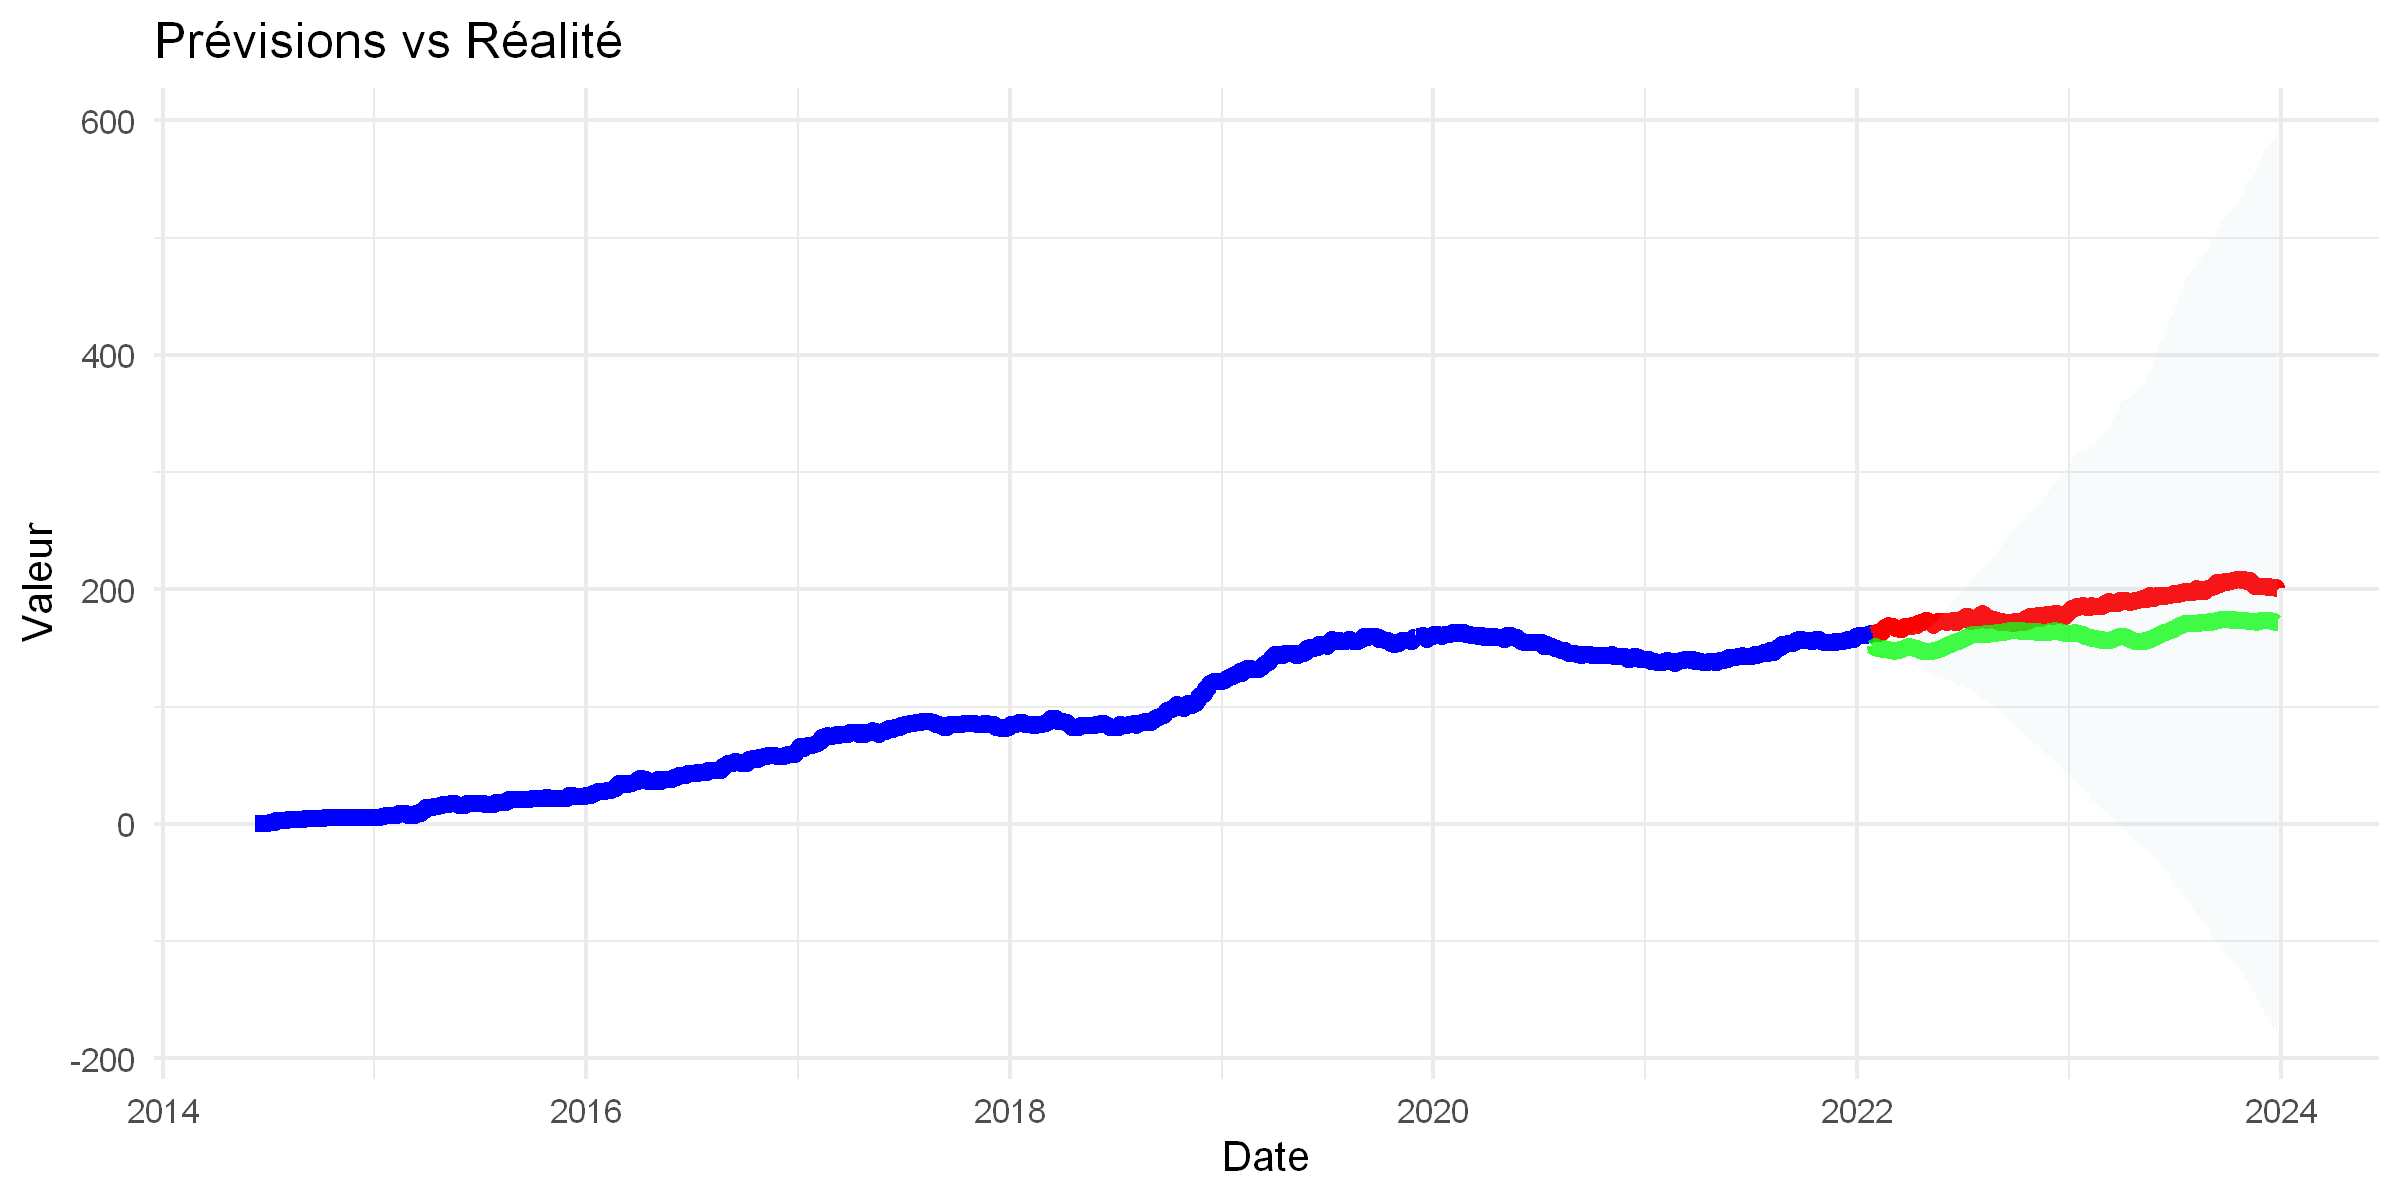

In [74]:
data_train$ds <- as.Date(data_train$ds)
data_test$ds <- as.Date(data_test$ds)
mf_data_test_forecast$ds <- as.Date(mf_data_test_forecast$ds)

ggplot() +
  geom_line(data = data_train, aes(x = ds, y = y), color = "blue", size = 5) +
  geom_line(data = data_test, aes(x = ds, y = y), color = "red", size = 5) +
  geom_line(data = mf_data_test_forecast, aes(x = ds, y = yhat), color = "green", linetype = "solid", size = 5, alpha = 0.8) +
  geom_ribbon(data = mf_data_test_forecast, aes(x = ds, ymin = yhat_lower, ymax = yhat_upper), fill = "lightblue", alpha = 0.1) +
  labs(title = "Prévisions vs Réalité", x = "Date", y = "Valeur", color = "Légende") +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right")


In [75]:
data_test_forecast = model_final %>% predict(data_test)
data_test_forecast[c('ds', 'yhat', 'yhat_lower', 'yhat_upper')] %>% head(7)

ds         yhat     yhat_lower yhat_upper
1 2022-01-29 151.4301 147.0854   155.5957  
2 2022-01-30 151.1609 146.7909   155.3836  
3 2022-01-31 151.2863 147.1958   155.2074  
4 2022-02-01 151.1503 146.7108   155.5123  
5 2022-02-02 150.9785 146.8454   155.3996  
6 2022-02-03 150.8016 146.3101   155.0271  
7 2022-02-04 150.5010 146.2217   155.1889

In [76]:
mape = mean_absolute_percentage_error(data_test$y,data_test_forecast$yhat)
rmse = sqrt(mean((data_test$y - data_test_forecast$yhat)^2))

In [77]:
print(mape)
print(rmse)

[1] 12.29535
[1] 24.63793


## Cross validation

On va présent effectuer une validation croisée.

La validation croisée est une technique très importante qui permet d'évaluer la performance du modèle prophet sur différentes parties de la série temporelle. Cela aide à comprendre comment le modèle se comporte avec différentes périodes de données, à simuler des conditions de prévision en temps réel et à estimer la qualité des prédictions du modèle.

### Importance de la cross validation

De manière générale, l'importance de la validation croisée réside autour de :

- **Évaluation des performances** : La validation croisée permet de mesurer l'erreur de prévision sur des données historiques en simulant des prédictions à différentes périodes de temps.
- **Optimisation des hyperparamètres** : Les résultats de la validation croisée peuvent aider à identifier les meilleures valeurs d'hyperparamètres pour le modèle prophet et à optimiser ses performances.
- **Réduction du surapprentissage** : La validation croisée aide à réduire le risque de surajustement (overfitting) en testant le modèle sur différentes parties de la série temporelle.
- **Prise de décision éclairée** : Les résultats de la validation croisée peuvent être utilisés pour décider si le modèle est prêt pour des prévisions réelles ou s'il nécessite des ajustements.

### Comment se fait la cross validation ?

La validation croisée avec prophet consiste à choisir des points de coupure (cutoffs) dans l'historique de la série. Pour chaque point de coupure, le modèle est entraîné sur les données jusqu'à ce point et testé sur un horizon spécifié (horizon). Les étapes consistent généralement en :
- Sélection des points de coupure : choisir les dates de coupure (cutoffs) dans la série temporelle. Cela détermine où la série est coupée pour chaque itération de validation croisée.
- Entraînement et test : Pour chaque date de coupure, les données avant la date de coupe sont utilisées pour entraîner le modèle, et les données après la date de coupe sont utilisées pour tester les prédictions.
- Calcul des métriques : Les prédictions effectuées sont comparées aux données réelles pour calculer des métriques d'évaluation telles que le MAPE (Mean Absolute Percentage Error) ou d'autres mesures d'erreur.

## Quels sont les paramètres qui sont généralement spécifiés ?

- **initial** : C'est la période d'entraînement initiale. C'est la quantité minimale de données nécessaire pour commencer l'entraînement. Cela établit le contexte historique que Prophet utilise pour créer des prévisions.
- **horizon** : C'est la durée sur laquelle on souhaitez évaluer les prévisions. Cela devrait correspondre à l'horizon de prévision que nous avons l'intention d'utiliser dans le modèle final. Par exemple, si l'on souhaite prévoir un mois dans le futur, notre horizon doit être fixé à 30 jours.
- **period** : C'est la quantité de temps entre chaque pli dans la validation croisée. Cela détermine l'intervalle à partir duquel de nouveaux plis commencent. La période peut être égale, inférieure ou supérieure à l'horizon.
- **cutoffs** : Ce sont les dates auxquelles chaque horizon commencera. Ce sont les points dans le temps où Prophet divisera les données et évaluera le modèle à l'aide de la validation croisée. En spécifiant les cutoffs, on peut contrôler où chaque pli de validation commence dans les données.
- **unit** : unité

### Illustration pour une meilleure compréhension

<div style="width:100%;text-align: center;">
    <img src="img_example_cross_validation.png" style="width:80%;height:100%;" /> <br>
</div>

## Effectuons la validation croisée

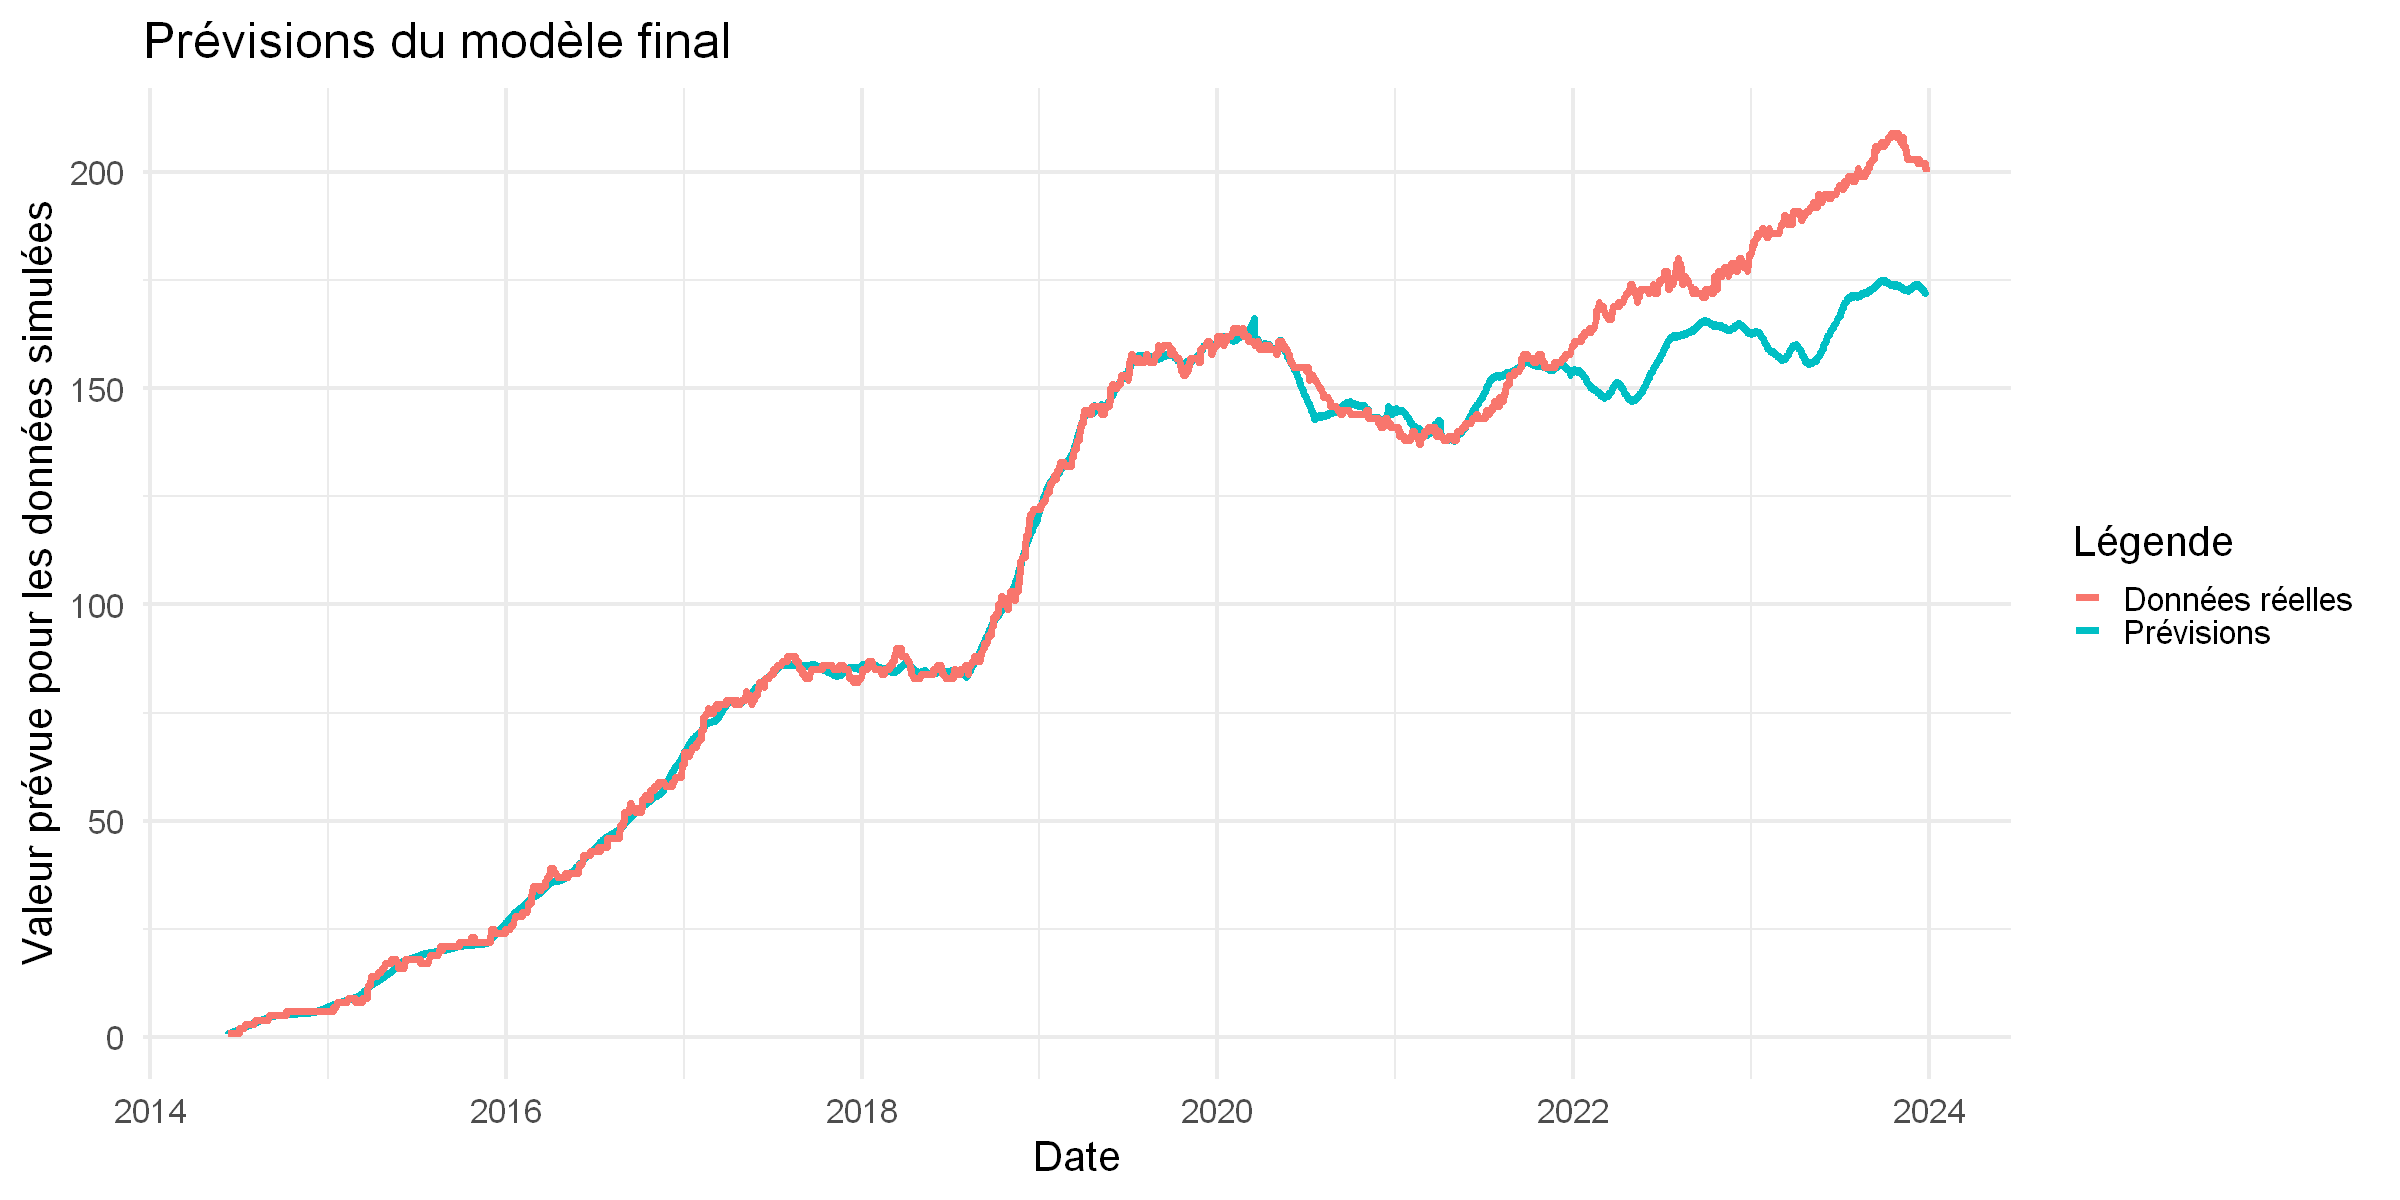

In [101]:
# Conversion des dates dans les données de mf_forecast et data
mf_forecast$ds <- as.POSIXct(mf_forecast$ds)
data$date <- as.POSIXct(data$date)

# Tracer les graphiques avec ggplot2
ggplot() +
  geom_line(data = mf_forecast, aes(x = ds, y = yhat, color = "Prévisions"), size = 2) +
  geom_line(data = data, aes(x = date, y = nombre_employes_total, color = "Données réelles"), size = 2) +
  labs(
    title = "Prévisions du modèle final",
    x = "Date",
    y = "Valeur prévue pour les données simulées",
    color = "Légende"
  ) +
  theme_minimal(base_size = 25) +
  theme(legend.position = "right")

In [97]:
#Valeur des paramètres :
initial <- 365*4 
period <- 180  
horizon <- 365
units <- 'days'

In [98]:
#cutoffs <- as.Date(c('2019-12-01', '2020-06-01', '2020-12-01', '2021-06-01', '2022-01-01', '2022-07-01', '2023-01-01'))


df.cv <- cross_validation(model_final, initial = initial, period = period,
                          horizon = horizon, units = units, #cutoffs = cutoffs
                         )

# Calculer les métriques d'évaluation
df.metrics <- performance_metrics(df.cv)

# Afficher les métriques d'évaluation
print(head(df.metrics,5))
print(tail(df.metrics,5))


Making 6 forecasts with cutoffs between 2018-08-12 and 2021-01-28



  horizon      mse     rmse      mae       mape      mdape      smape  coverage
1 37 days 52.64714 7.255835 5.826609 0.04350302 0.03741279 0.04302824 0.2716895
2 38 days 54.95152 7.412929 5.953074 0.04451297 0.03812929 0.04404156 0.2716895
3 39 days 57.23275 7.565233 6.076977 0.04549047 0.03862297 0.04502190 0.2739726
4 40 days 59.66776 7.724491 6.198661 0.04644021 0.03923833 0.04597040 0.2785388
5 41 days 62.07200 7.878579 6.315624 0.04735826 0.03960496 0.04688834 0.2831050
     horizon      mse     rmse      mae      mape     mdape     smape  coverage
325 361 days 2818.562 53.09013 45.87138 0.3030927 0.2378554 0.3021896 0.9018265
326 362 days 2834.491 53.23993 46.00875 0.3040152 0.2378554 0.3029235 0.9063927
327 363 days 2849.933 53.38477 46.14741 0.3049697 0.2378554 0.3036656 0.9109589
328 364 days 2863.852 53.51497 46.27998 0.3058911 0.2378554 0.3043724 0.9155251
329 365 days 2877.404 53.64144 46.40777 0.3068141 0.2378554 0.3050536 0.9200913


In [102]:
# Visualiser les résultats de la validation croisée
a = plot_cross_validation_metric(df.cv, metric = 'mape')

Plus l'horizon est loin, plus le mape est élevé, ce qui pourrait signifier que le modèle est plus performant (plus précis) pour les horizons proches que loin.

In [103]:
# Visualiser les résultats de la validation croisée
b = plot_cross_validation_metric(df.cv, metric = 'rmse')

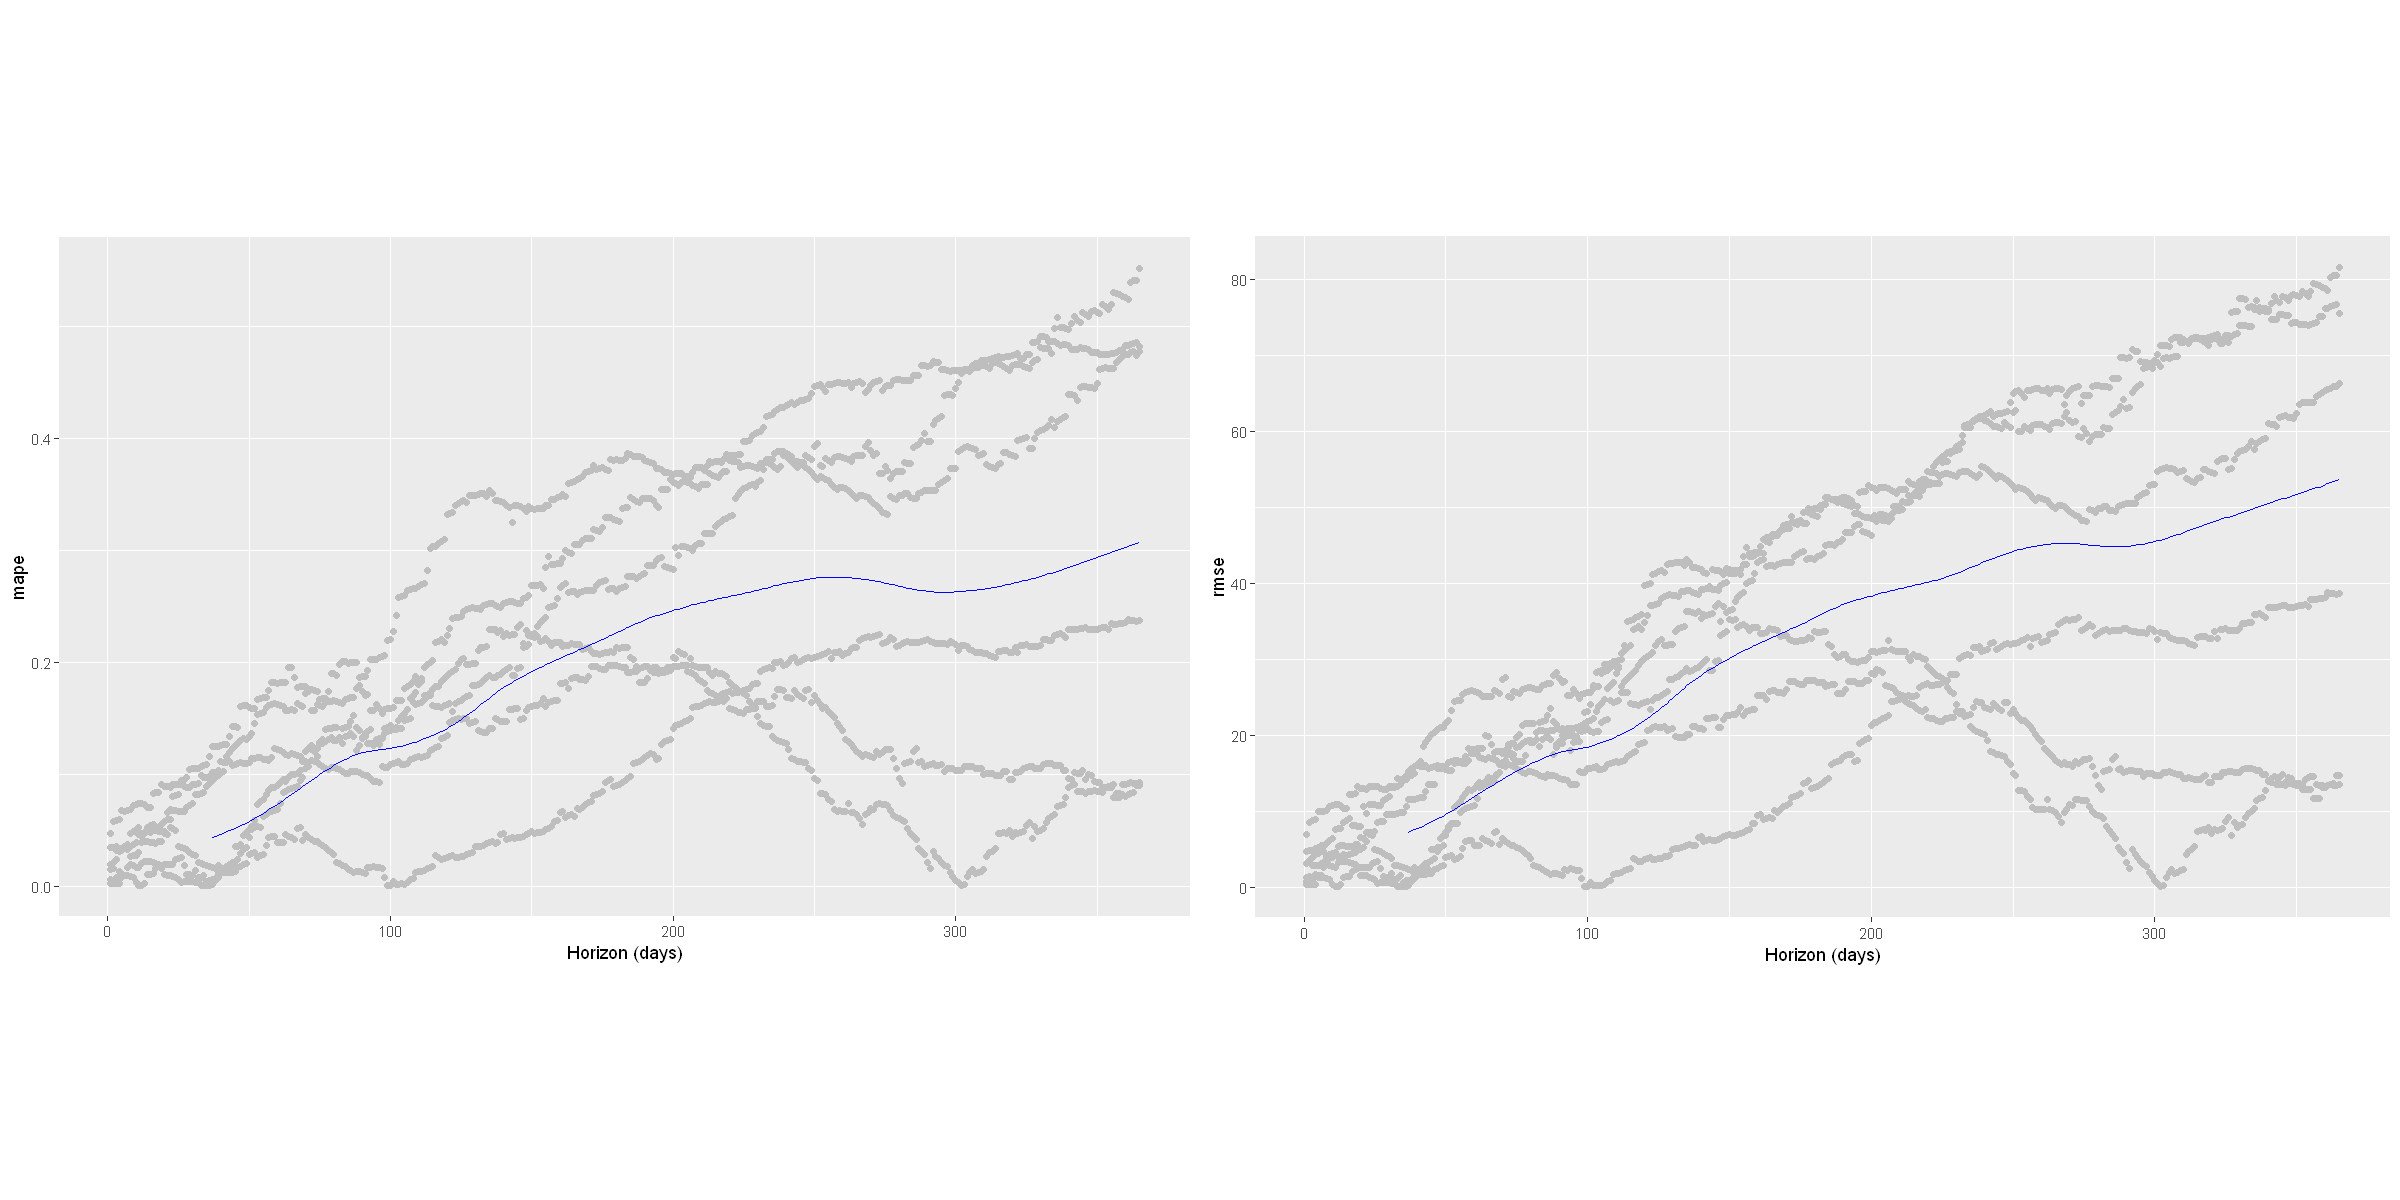

In [104]:
grid.arrange(a,b,ncol=2)